In [2]:
!pip install gymnasium


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install "gymnasium[classic-control]"


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install "gymnasium[toy-text]


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Question 1: Your first task is to get gymnasium up and running and transfer the frozen lake

In [6]:
from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


sns.set_theme()

In [7]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved


params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("../../_static/img/tutorials/"),
)
params

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exist
params.savefig_folder.mkdir(parents=True, exist_ok=True)

In [8]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

In [9]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # Find the indices where the Q-value equals the maximum value
            # Choose a random action from the indices where the Q-value is maximum
            max_ids = np.where(qtable[state, :] == max(qtable[state, :]))[0]
            action = rng.choice(max_ids)
        return action

Action size: 4
State size: 25


In [10]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

In [11]:
def run_env(params):
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

In [12]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(order="F"),
            "Steps": steps.flatten(order="F"),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

In [13]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [14]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [15]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

Map size: 4x4


Cumulative reward:  1927.0


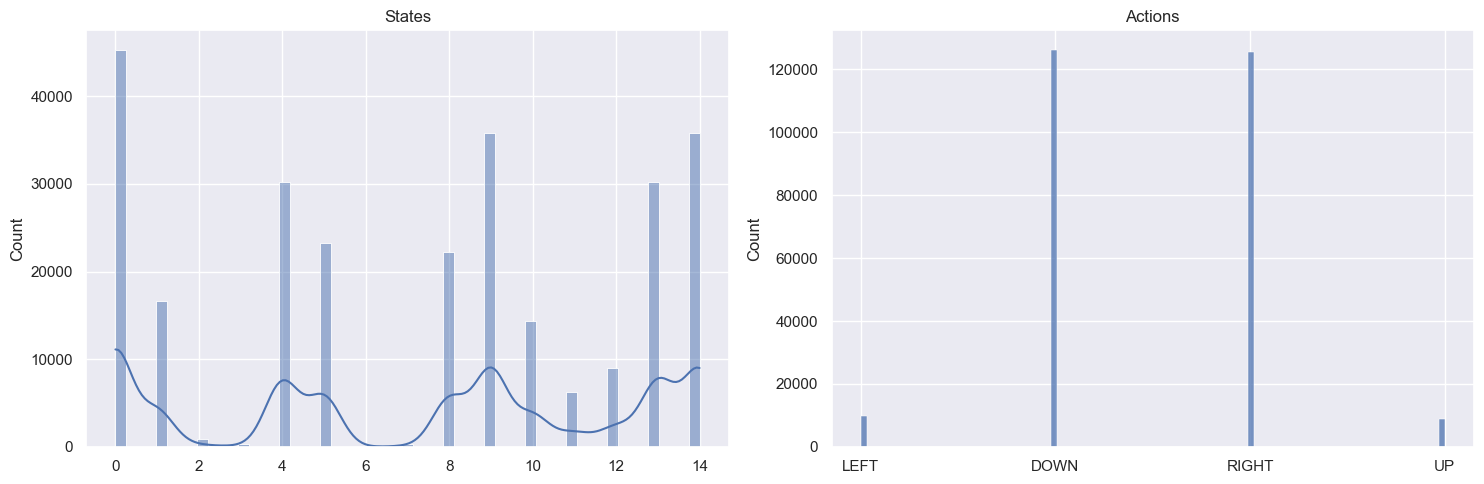

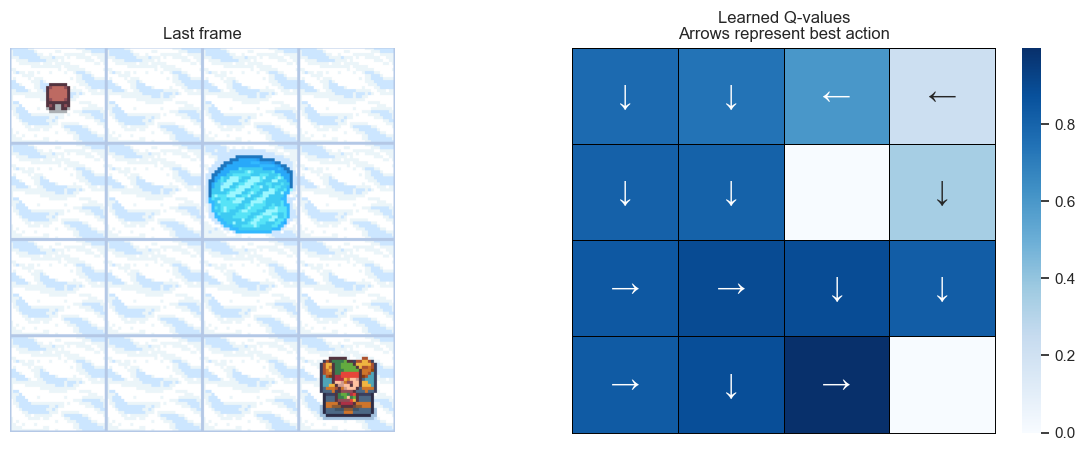

Map size: 7x7


Cumulative reward:  1745.0


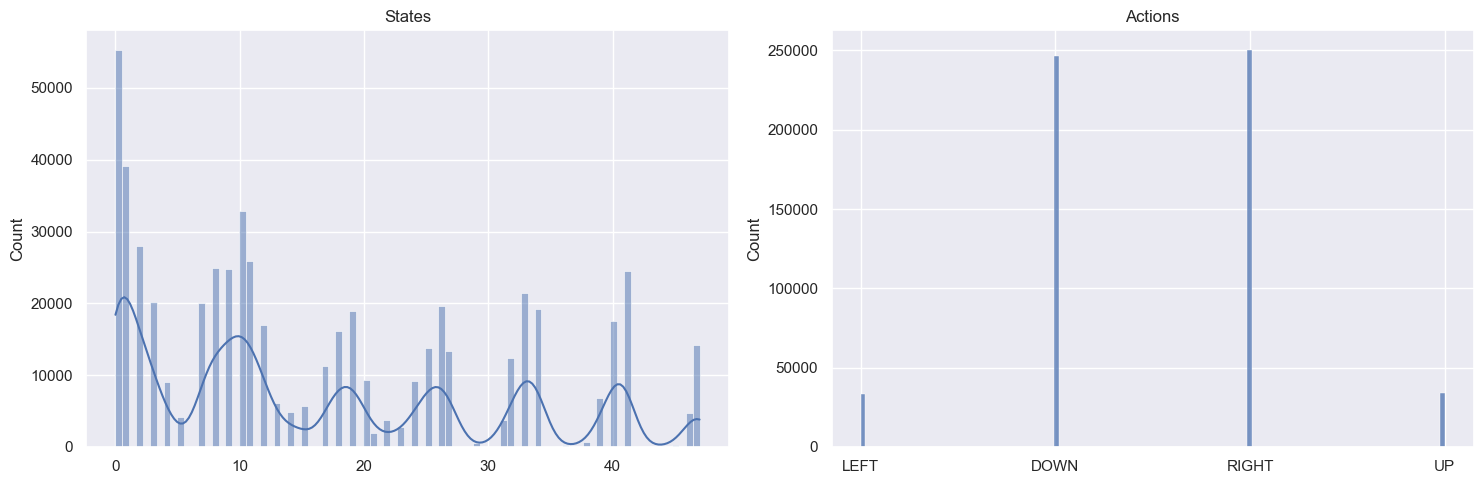

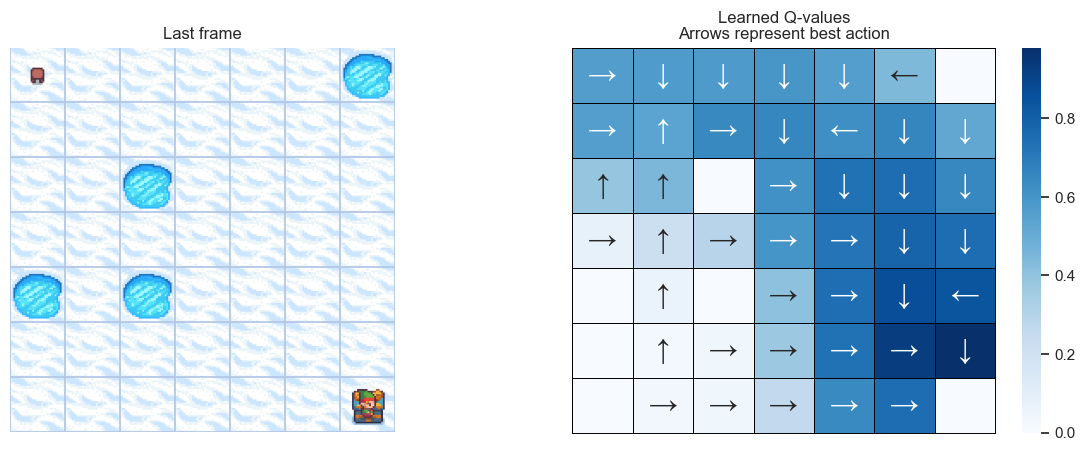

Map size: 9x9


Cumulative reward:  1448.0


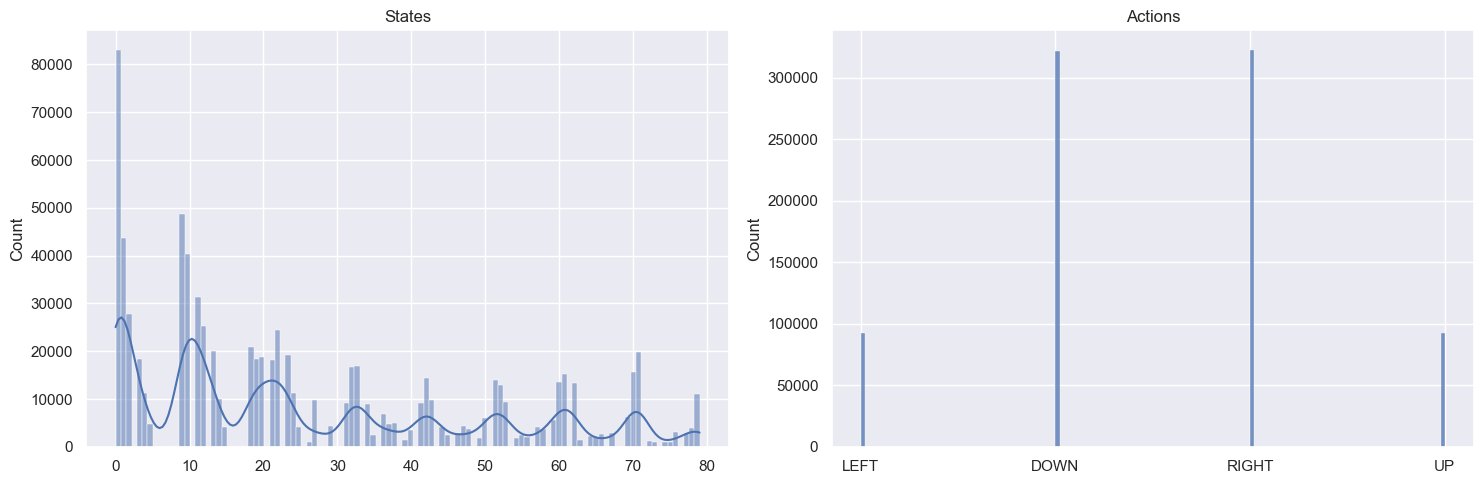

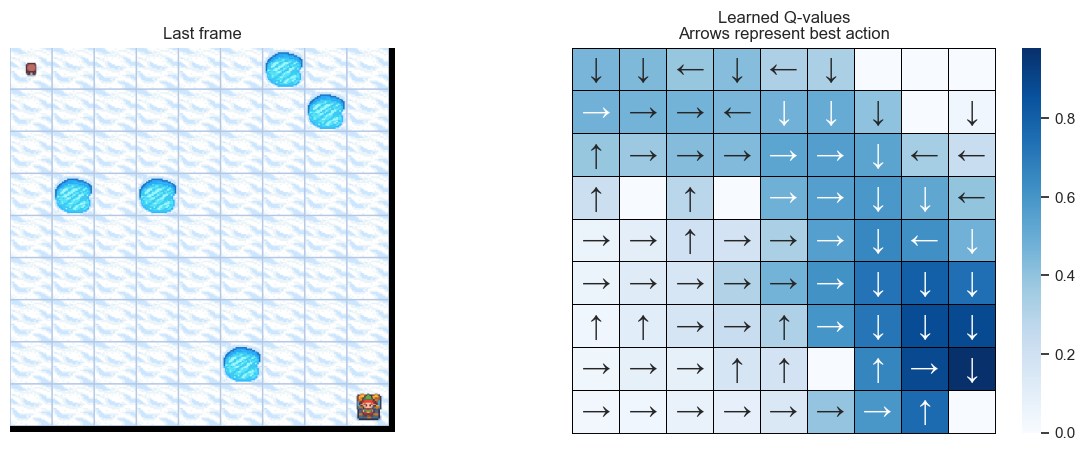

Map size: 11x11


Cumulative reward:  1061.0


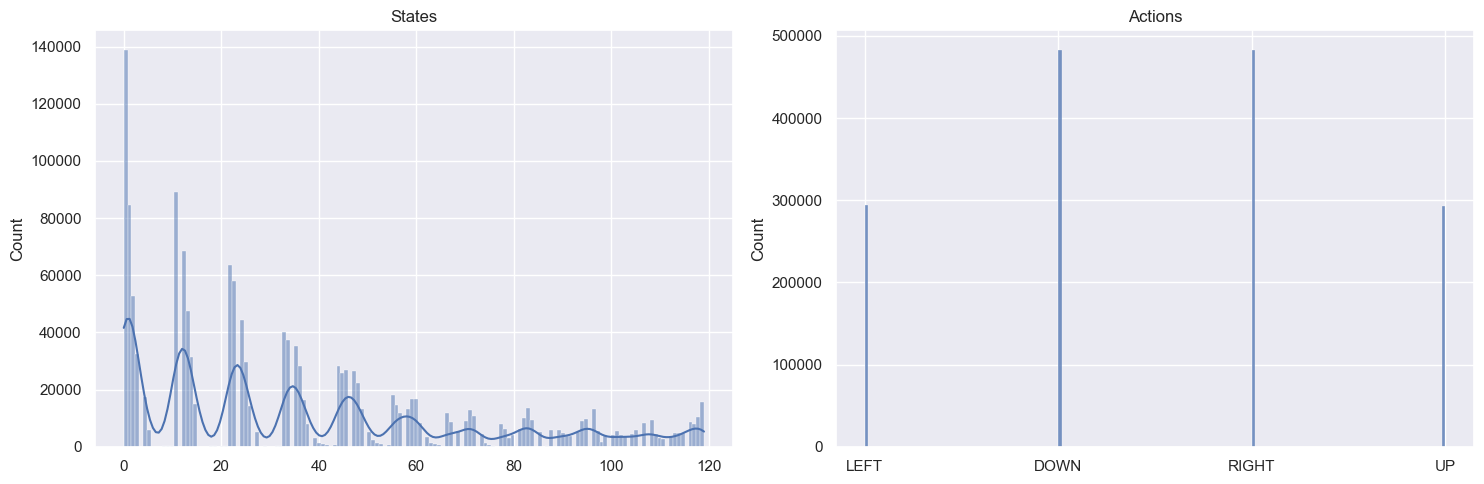

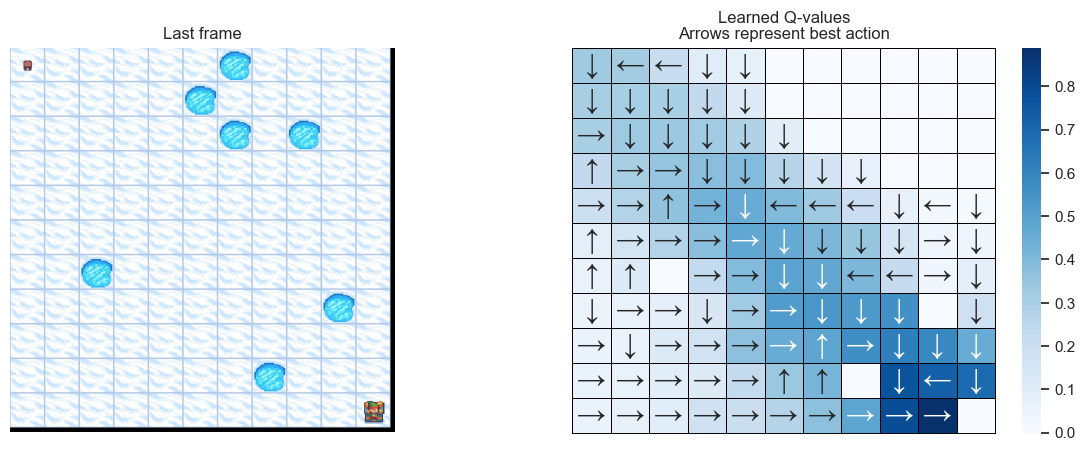

In [19]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()
results_summary = []

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # Set the seed to get reproducible results when sampling the action space
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env(params)

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    cumulative_reward = res["cum_rewards"].iloc[-1]
    print(f"Cumulative reward: ", cumulative_reward)  
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs
    results_summary.append({
            "map_size": map_size,
            "cumulative_reward": cumulative_reward
        })

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()

In [22]:
summary_df = pd.DataFrame(results_summary)
print(summary_df)

   map_size  cumulative_reward
0         4             1927.0
1         7             1745.0
2         9             1448.0
3        11             1061.0


##### 1. Change values of gamma to .01, .2, .5, and .99 and rerun the tutorial code

I tried to iterate through the four values of gamma and for each map size. Stored the final cumulative reward for each value of gamma and the map size.


Running for gamma=0.01
Map size: 4x4


Cumulative reward for gamma=0.01, map size=4: 1909.0


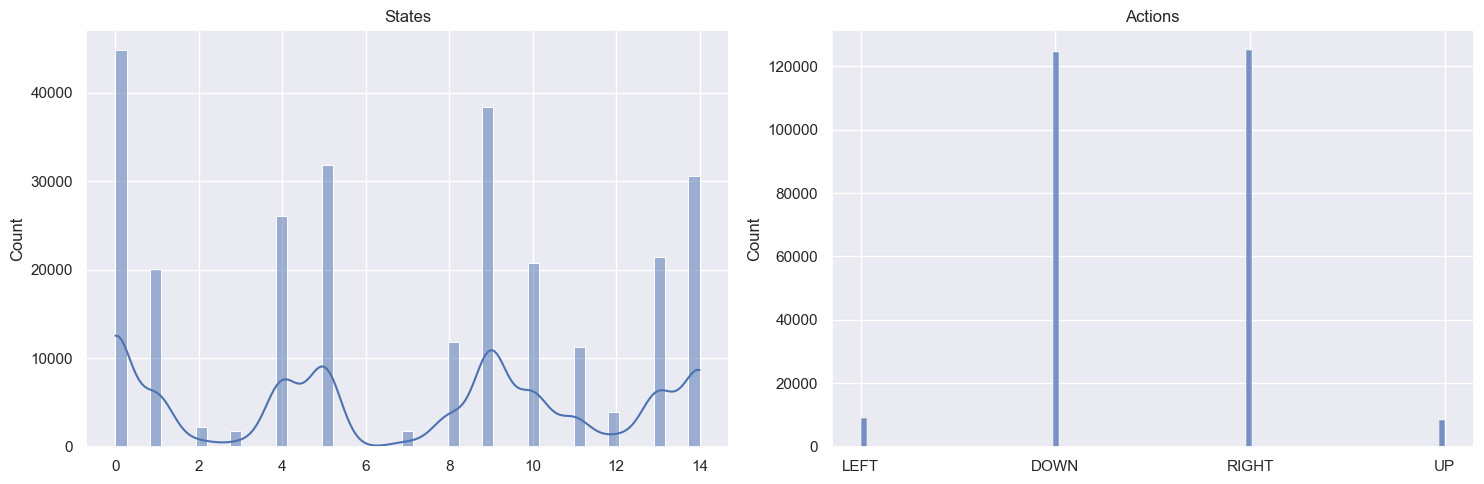

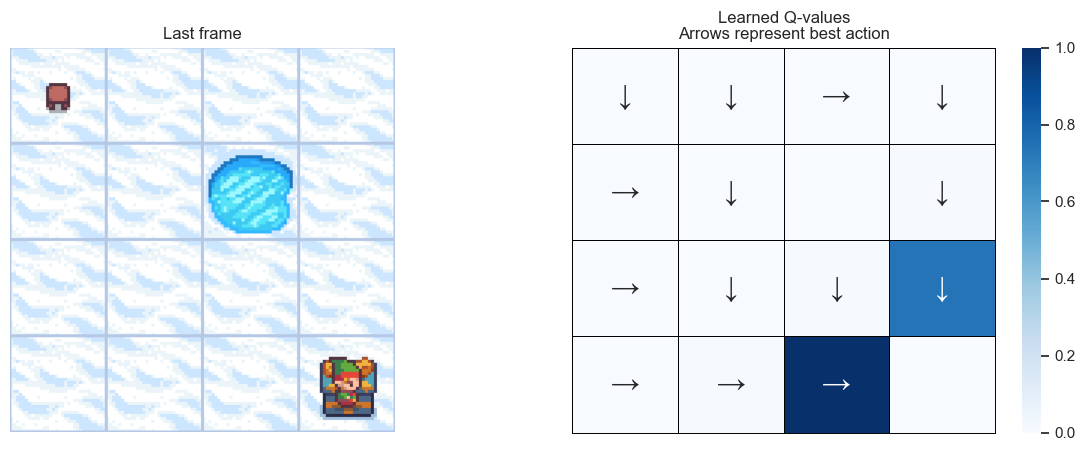

Map size: 7x7


Cumulative reward for gamma=0.01, map size=7: 1702.0


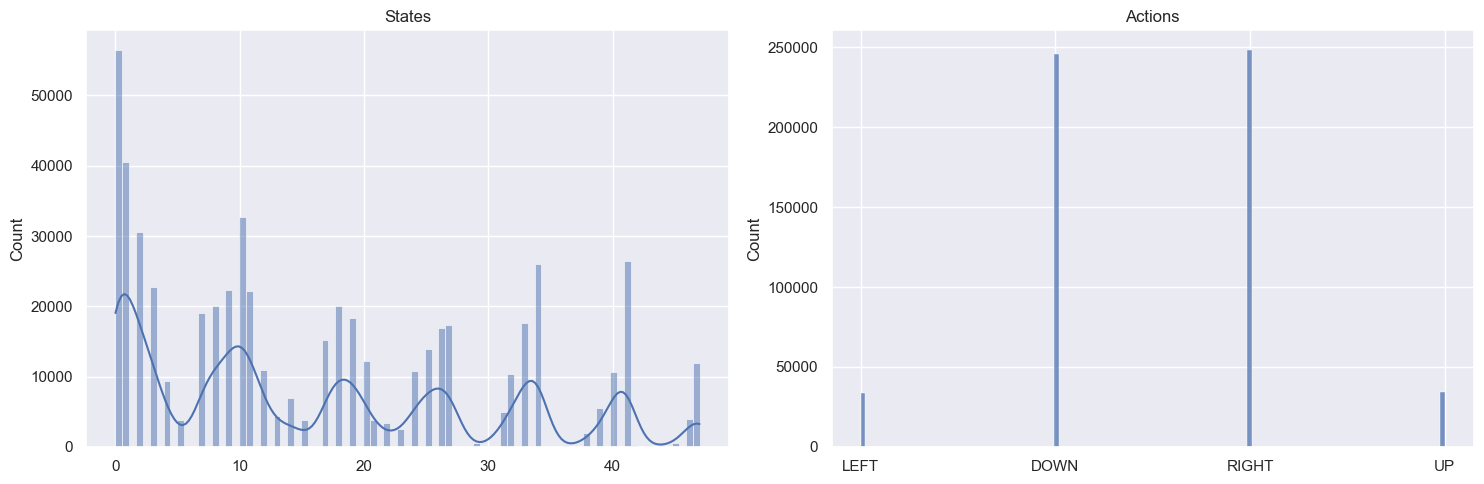

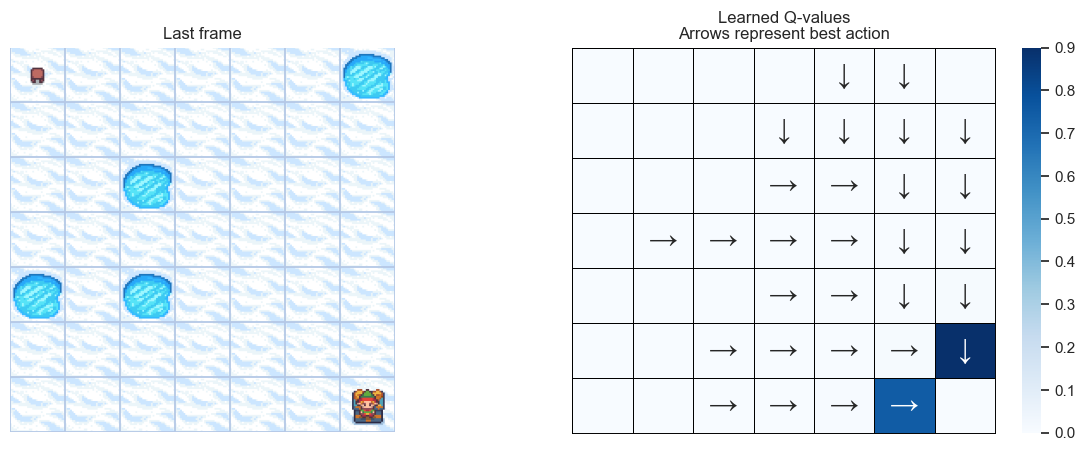

Map size: 9x9


Cumulative reward for gamma=0.01, map size=9: 1040.0


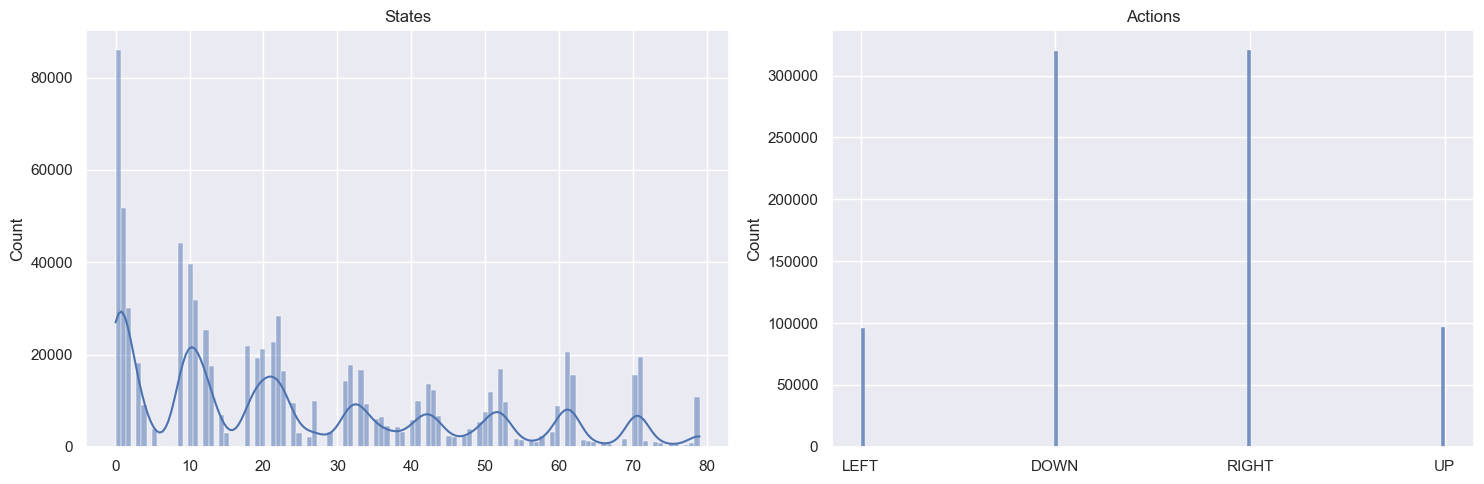

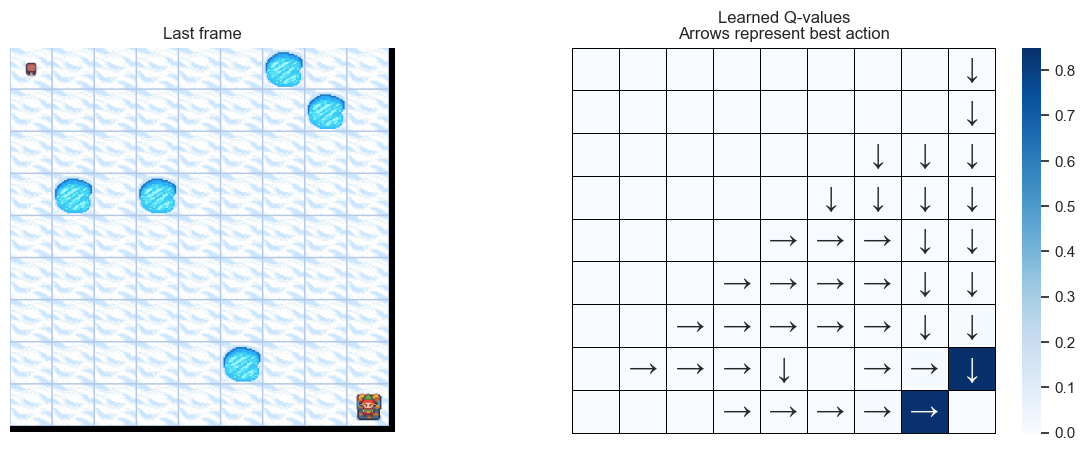

Map size: 11x11


Cumulative reward for gamma=0.01, map size=11: 369.0


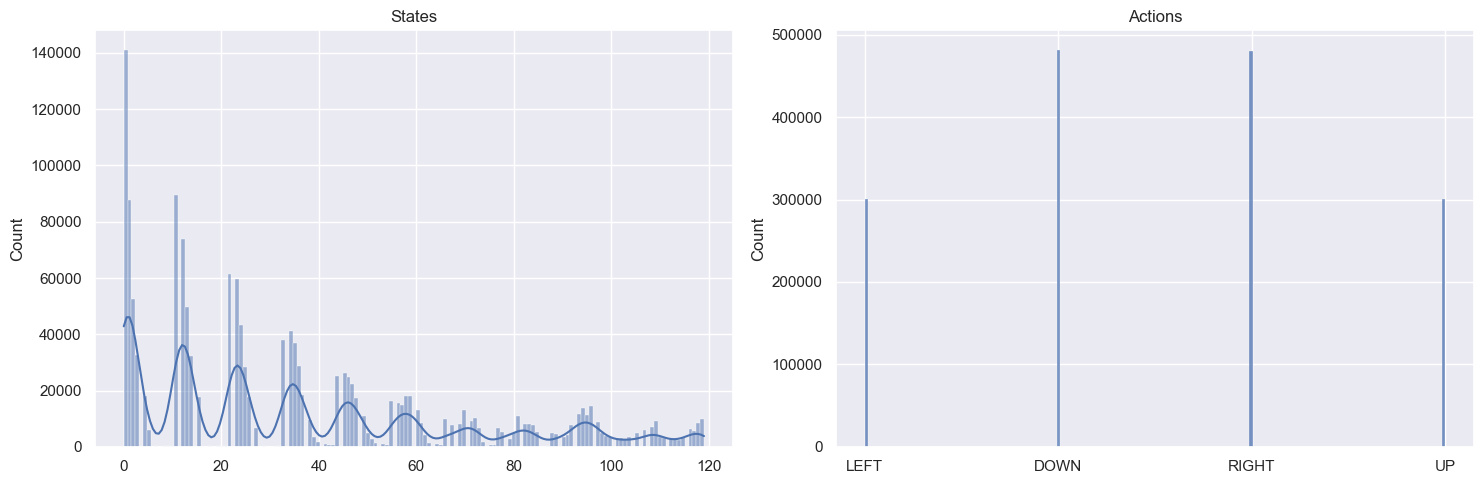

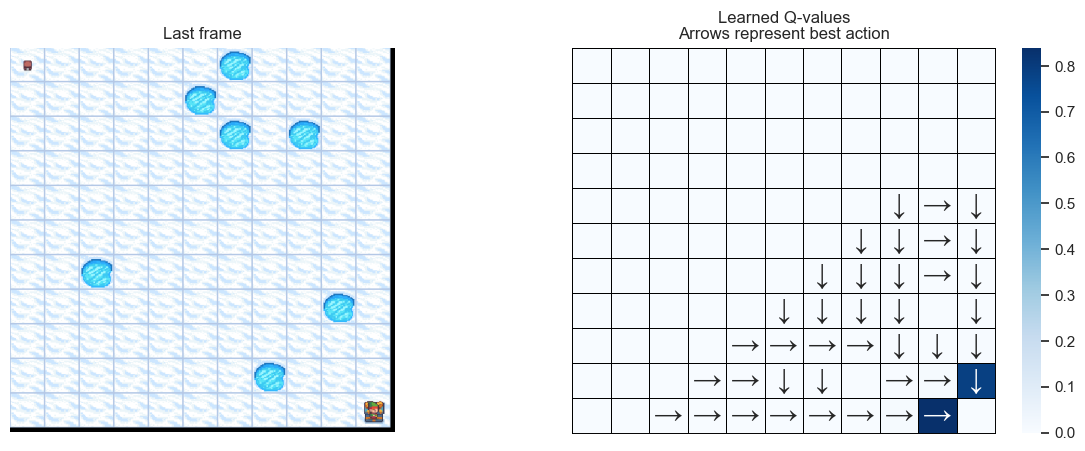


Running for gamma=0.2
Map size: 4x4


Cumulative reward for gamma=0.2, map size=4: 1976.0


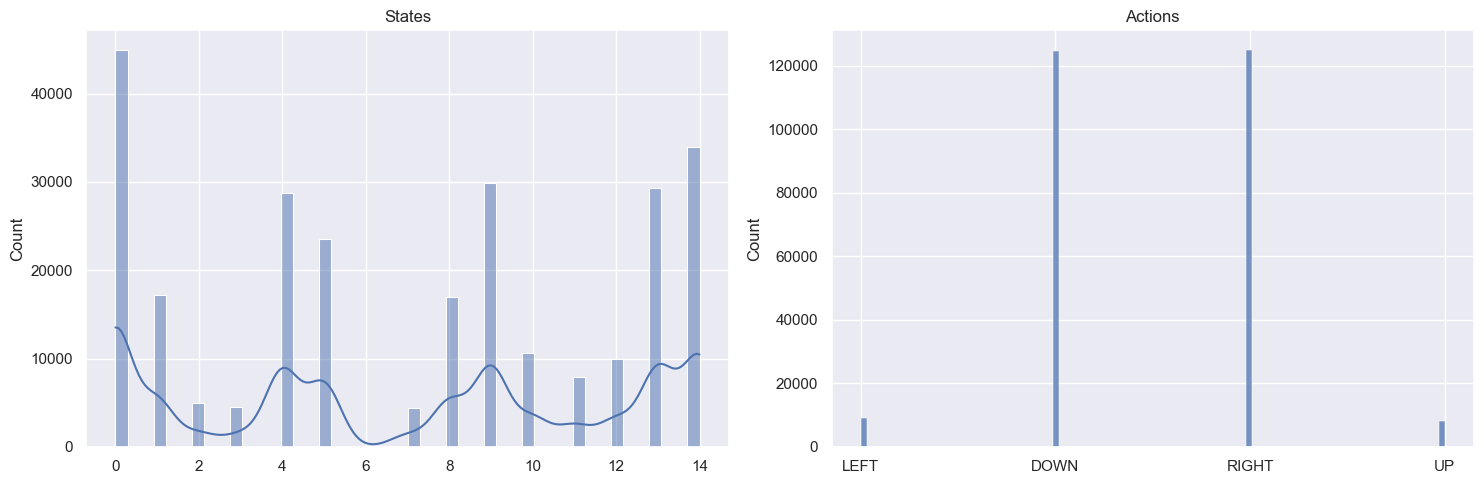

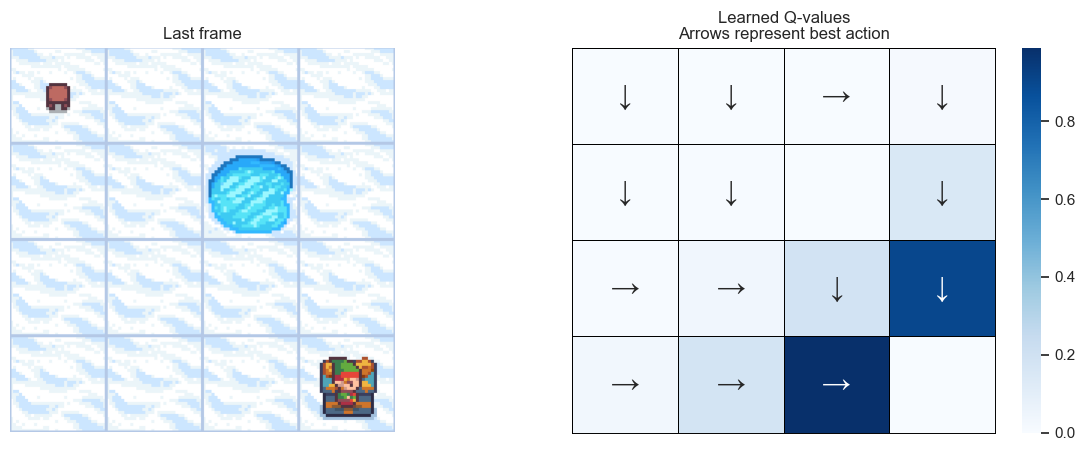

Map size: 7x7


Cumulative reward for gamma=0.2, map size=7: 1637.0


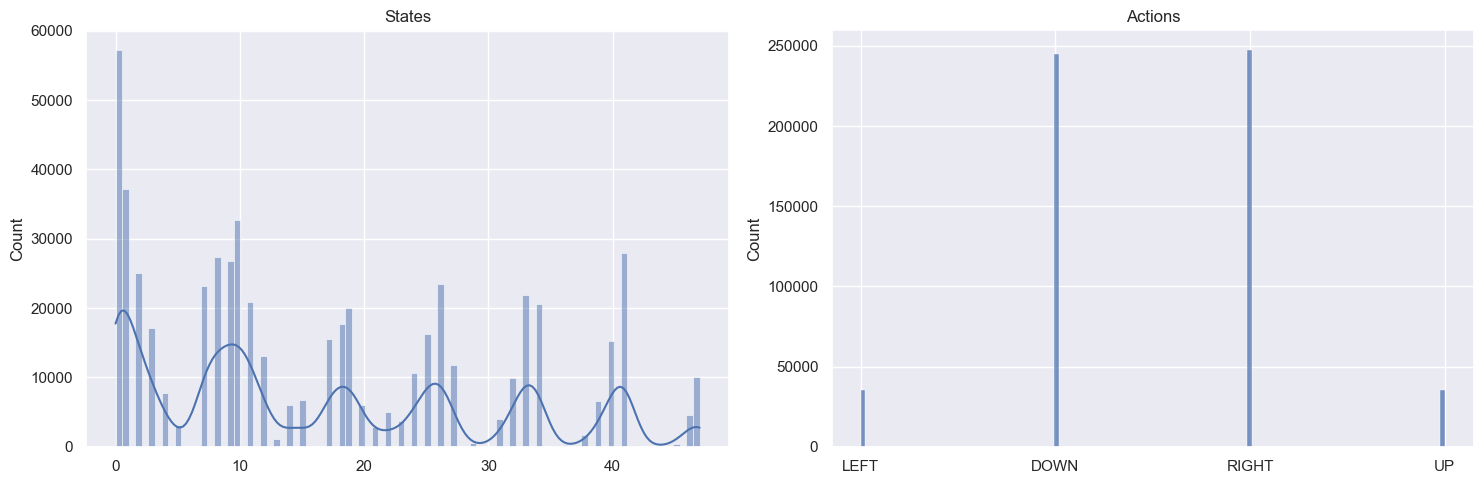

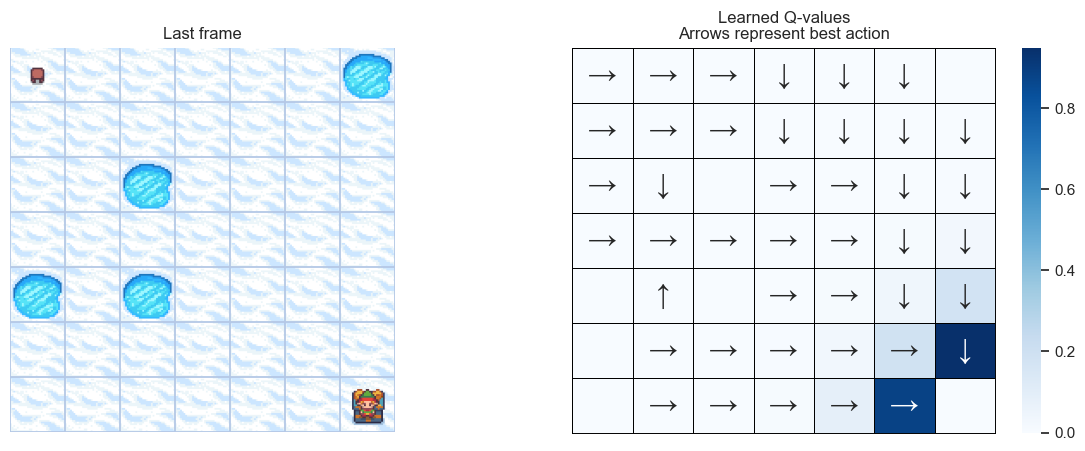

Map size: 9x9


Cumulative reward for gamma=0.2, map size=9: 1543.0


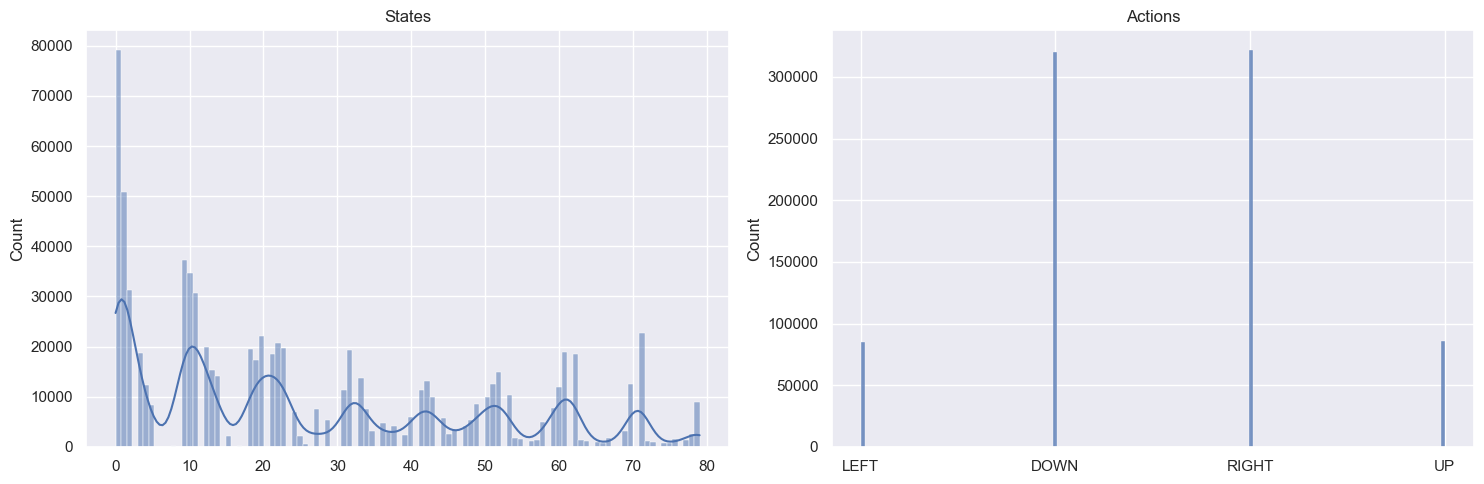

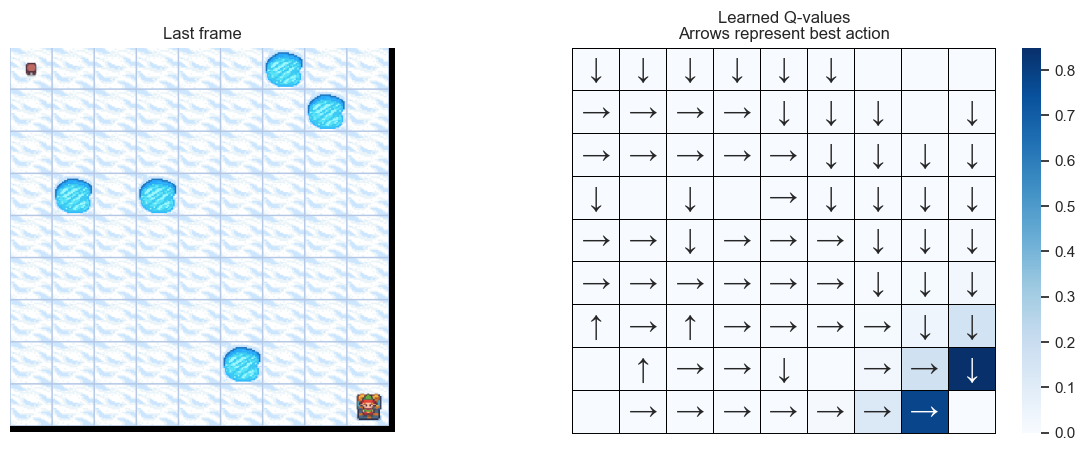

Map size: 11x11


Cumulative reward for gamma=0.2, map size=11: 1078.0


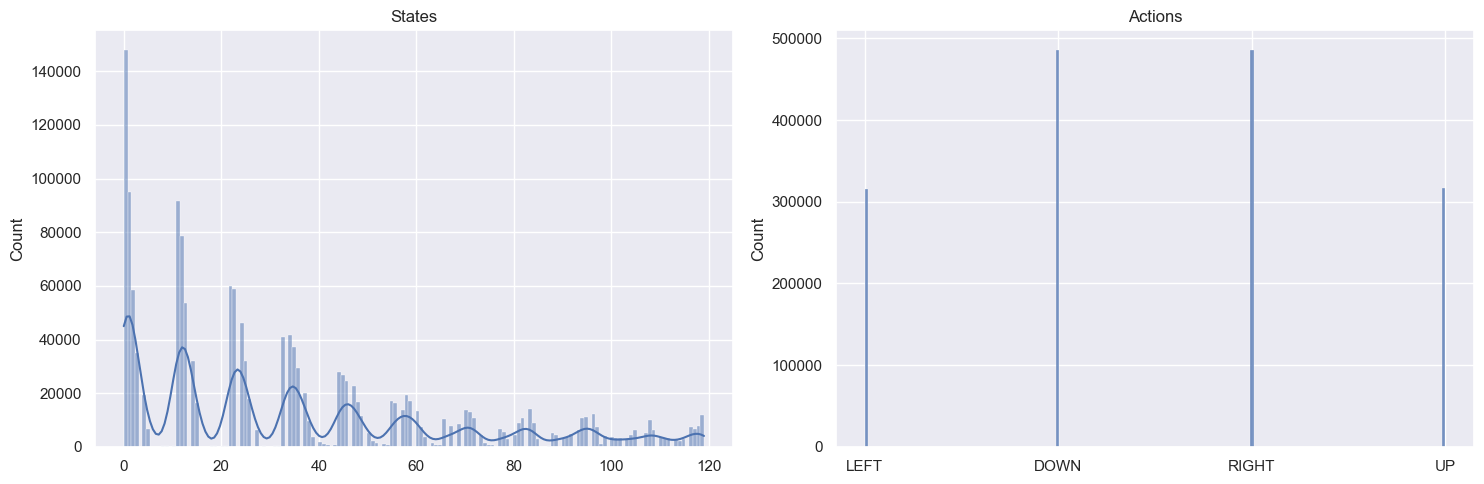

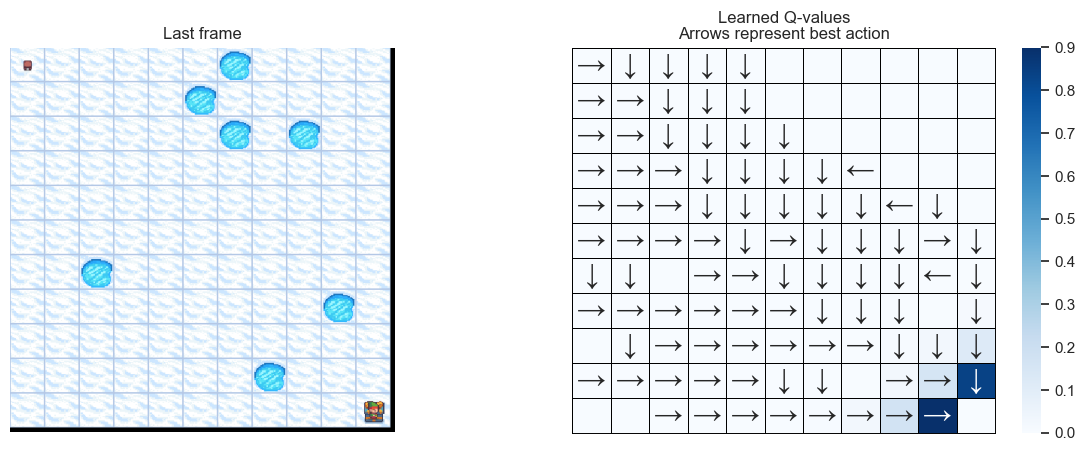


Running for gamma=0.5
Map size: 4x4


Cumulative reward for gamma=0.5, map size=4: 1898.0


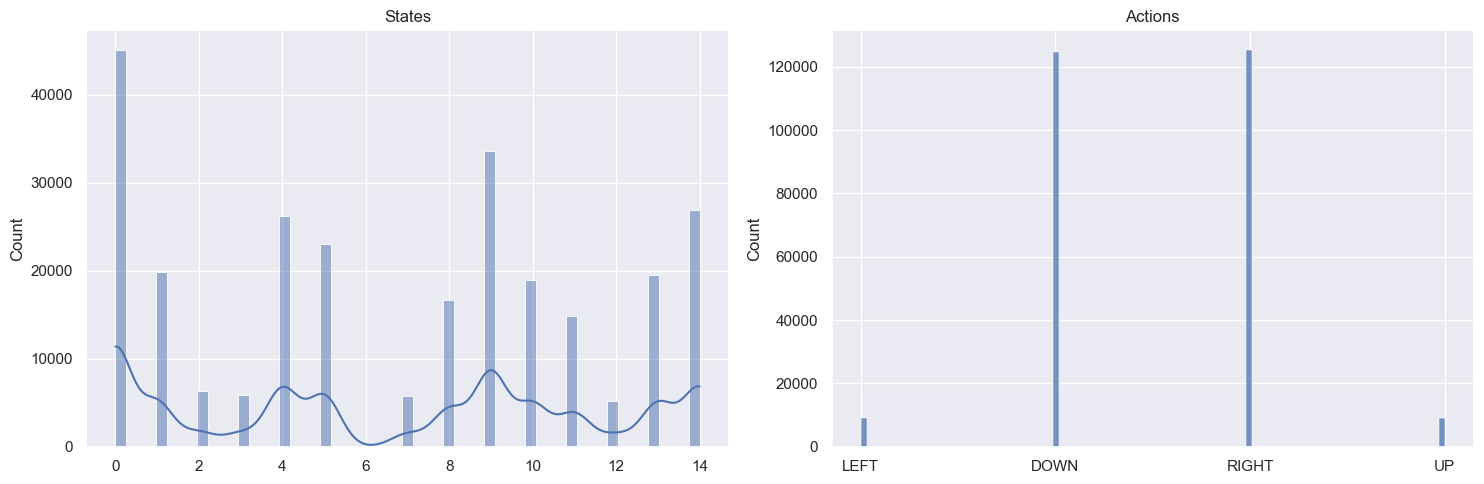

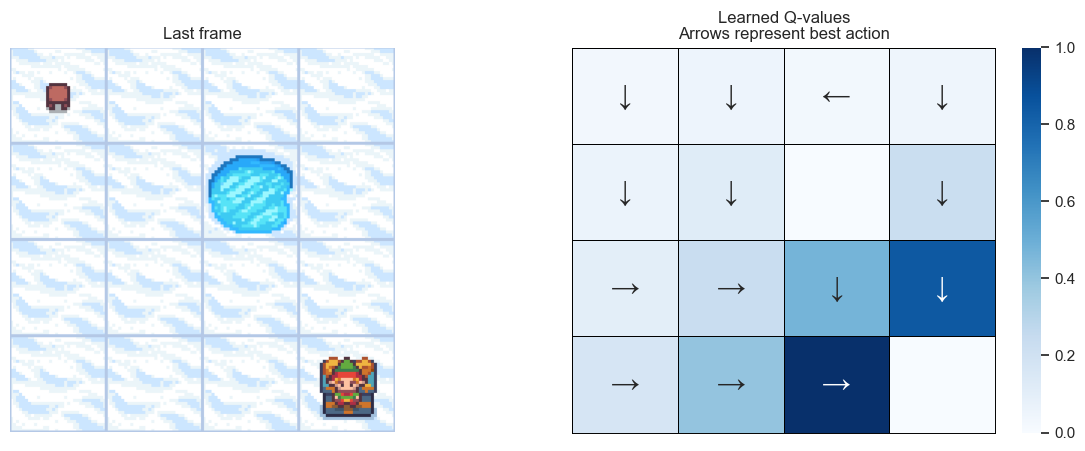

Map size: 7x7


Cumulative reward for gamma=0.5, map size=7: 1867.0


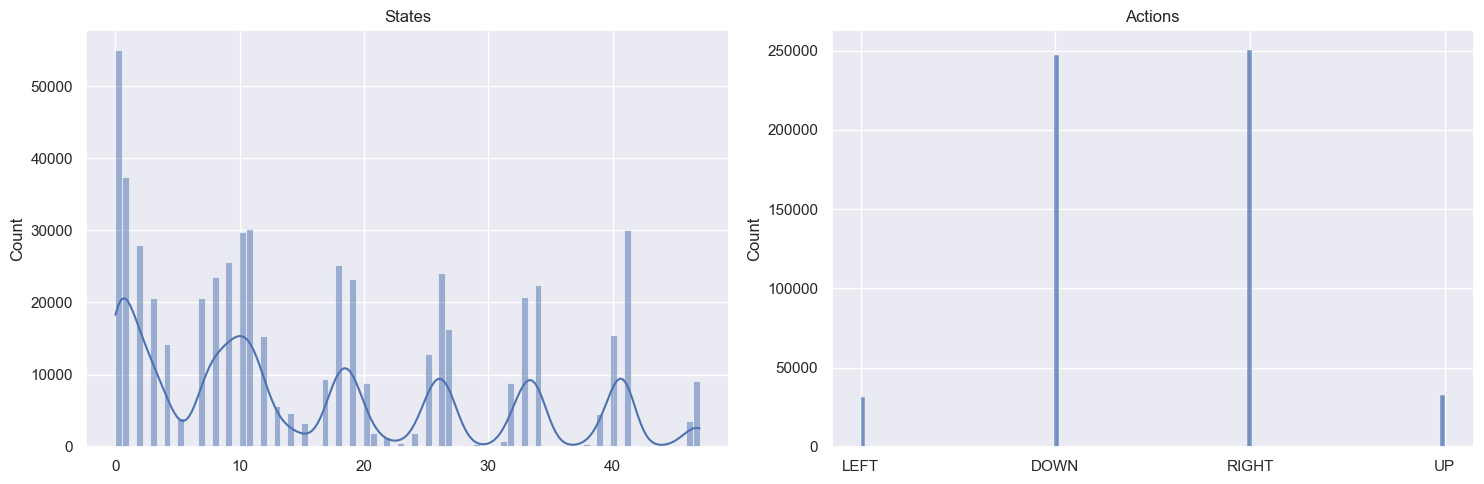

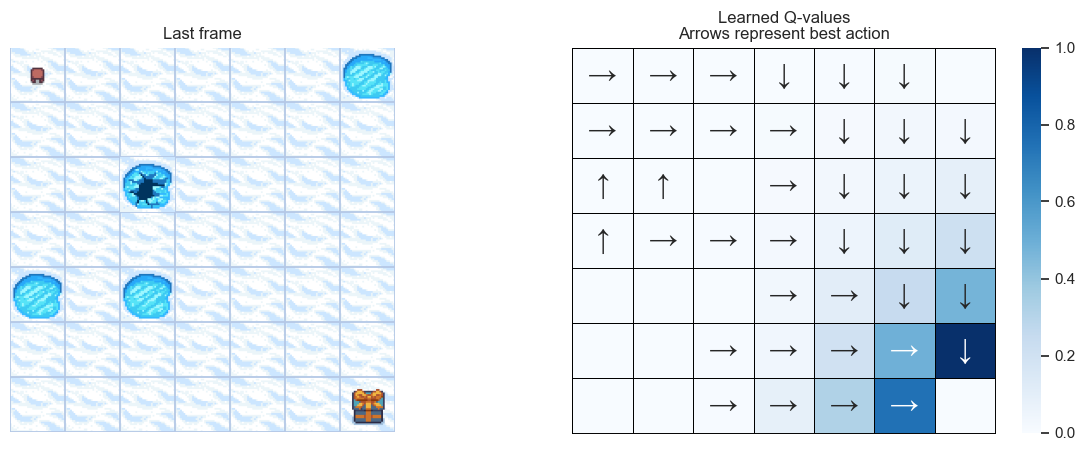

Map size: 9x9


Cumulative reward for gamma=0.5, map size=9: 1569.0


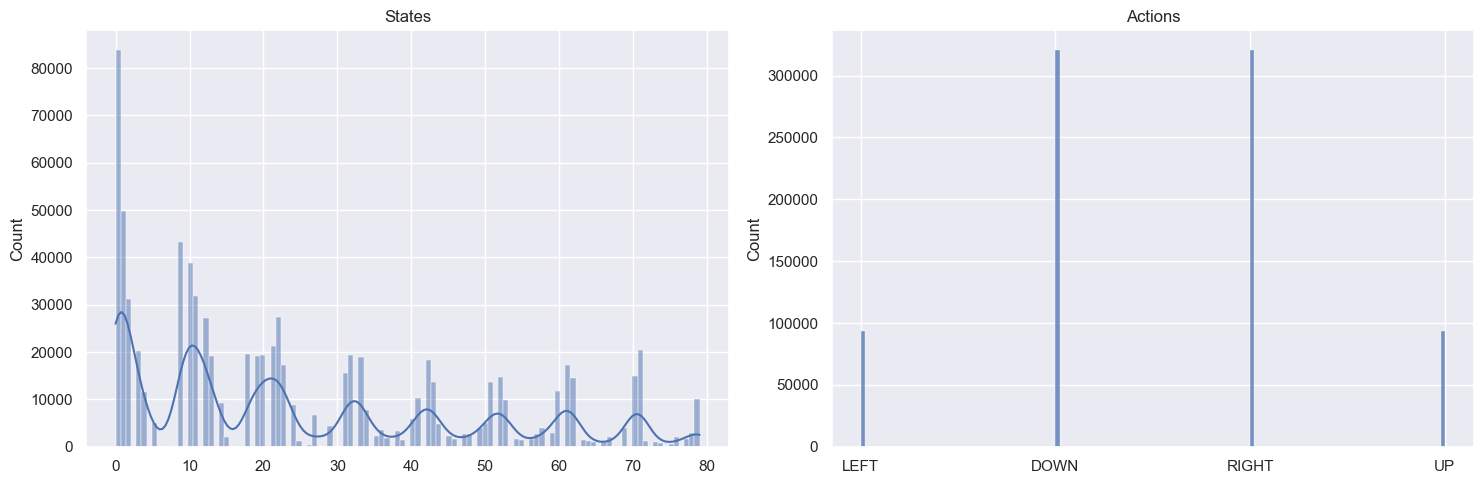

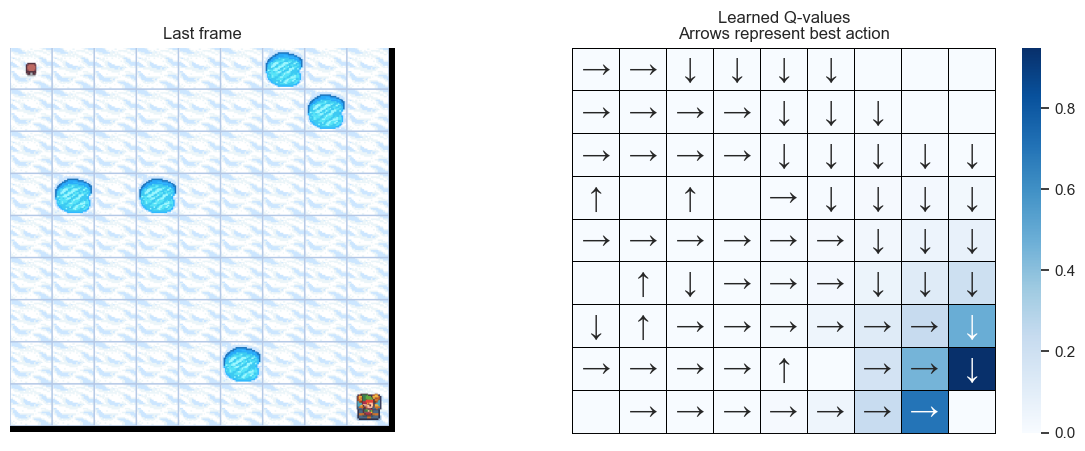

Map size: 11x11


Cumulative reward for gamma=0.5, map size=11: 791.0


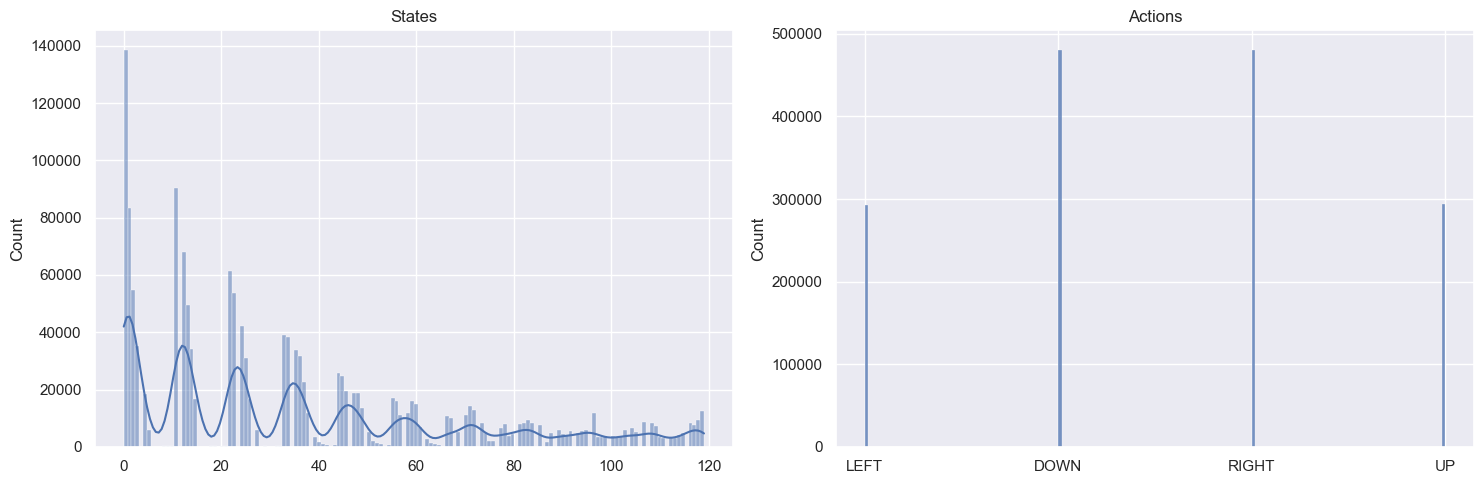

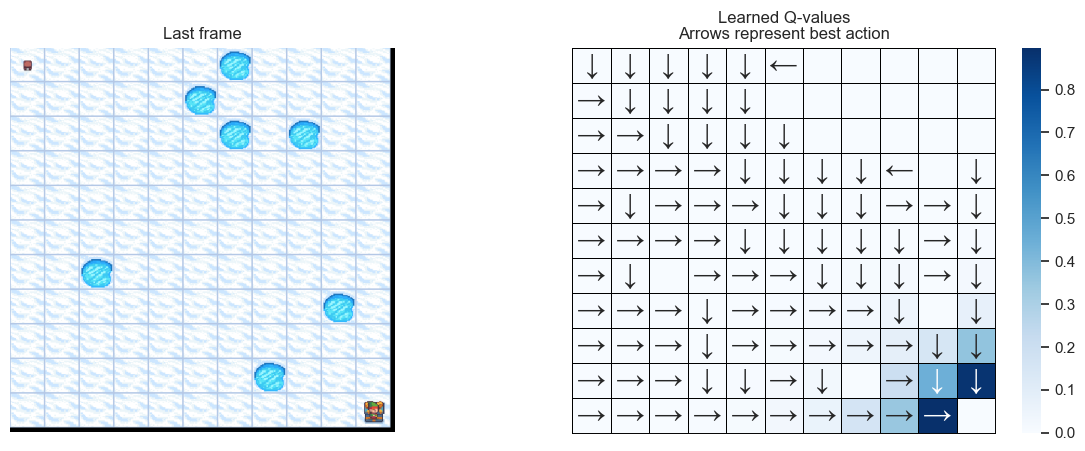


Running for gamma=0.99
Map size: 4x4


Cumulative reward for gamma=0.99, map size=4: 1898.0


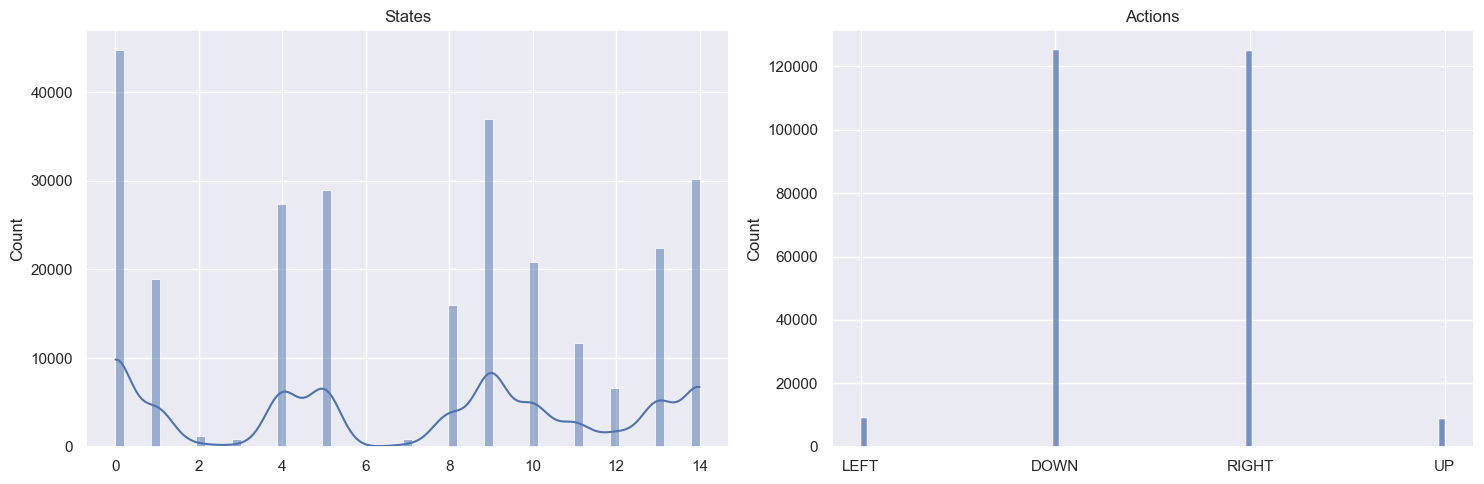

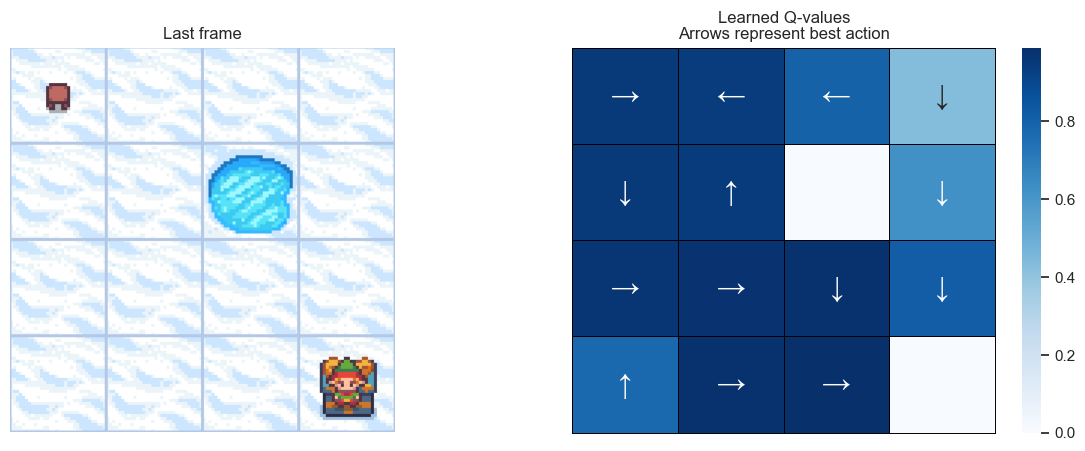

Map size: 7x7


Cumulative reward for gamma=0.99, map size=7: 1832.0


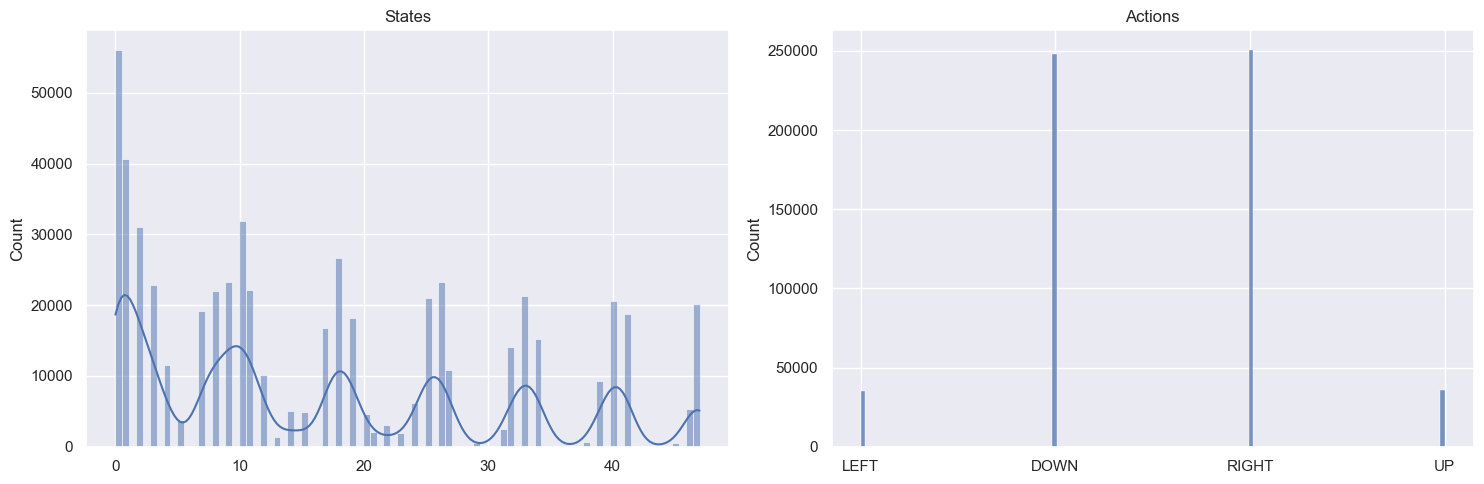

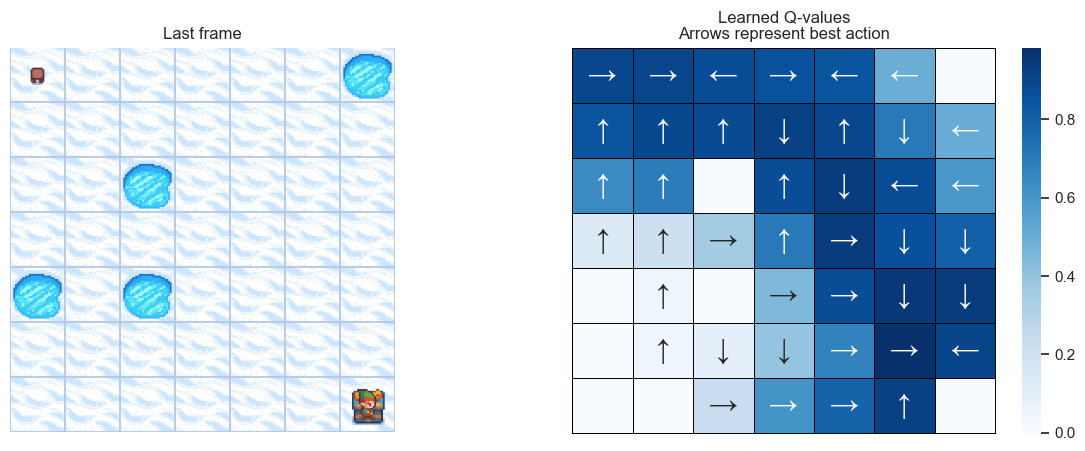

Map size: 9x9


Cumulative reward for gamma=0.99, map size=9: 1670.0


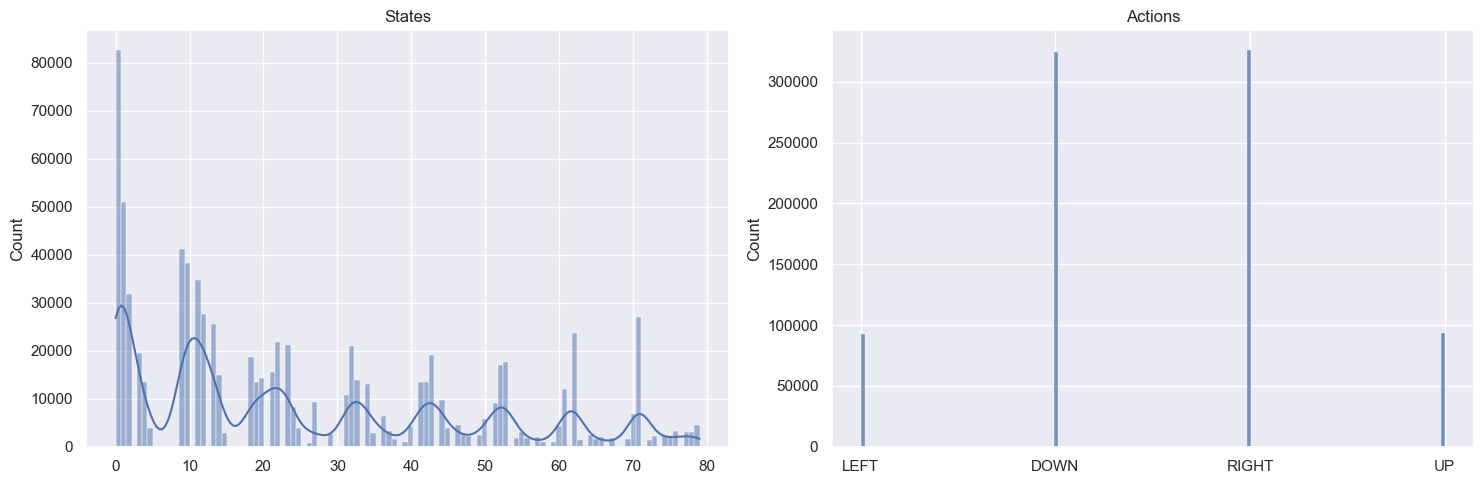

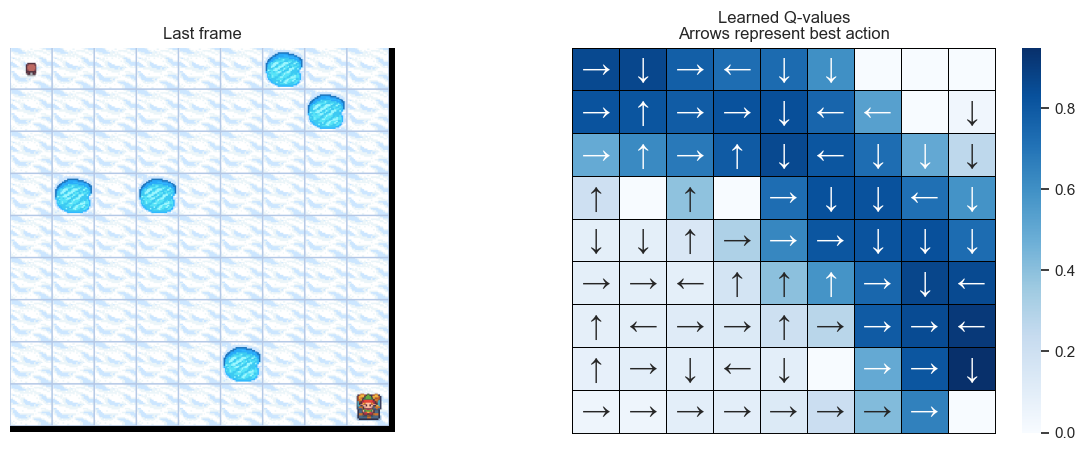

Map size: 11x11


Cumulative reward for gamma=0.99, map size=11: 1081.0


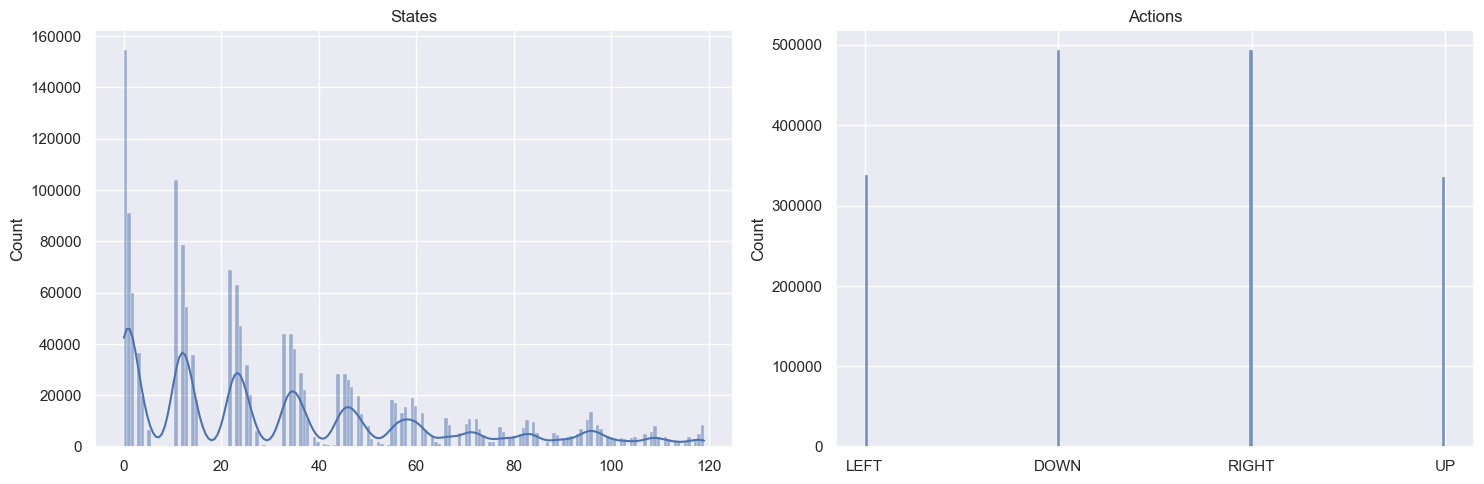

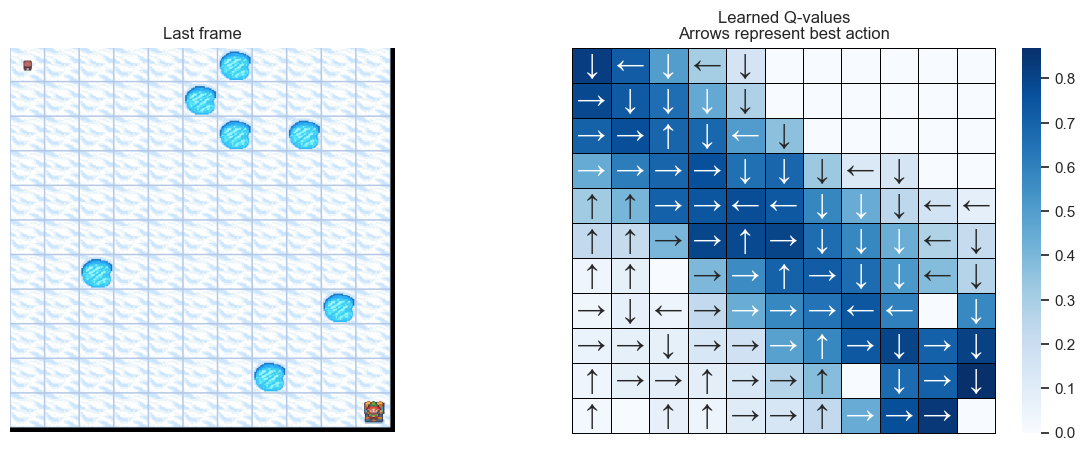

In [24]:
gammas = [0.01, 0.2, 0.5, 0.99]
res_all = pd.DataFrame()
st_all = pd.DataFrame()
gamma_results_summary = []

for gamma in gammas:
    print(f"\nRunning for gamma={gamma}")

    updated_params = params._replace(
        gamma=gamma,
        action_size=None,  
        state_size=None   
    )

    map_sizes = [4, 7, 9, 11]  
    for map_size in map_sizes:
        env = gym.make(
            "FrozenLake-v1",
            is_slippery=updated_params.is_slippery,
            render_mode="rgb_array",
            desc=generate_random_map(
                size=map_size, p=updated_params.proba_frozen, seed=updated_params.seed
            ),
        )

        updated_params = updated_params._replace(
            action_size=env.action_space.n,
            state_size=env.observation_space.n,
        )
        env.action_space.seed(updated_params.seed)

        learner = Qlearning(
            learning_rate=updated_params.learning_rate,
            gamma=updated_params.gamma,
            state_size=updated_params.state_size,
            action_size=updated_params.action_size,
        )
        explorer = EpsilonGreedy(epsilon=updated_params.epsilon)

        print(f"Map size: {map_size}x{map_size}")
        rewards, steps, episodes, qtables, all_states, all_actions = run_env(updated_params)

        res, st = postprocess(episodes, updated_params, rewards, steps, map_size)
        cumulative_reward = res["cum_rewards"].iloc[-1]
        print(f"Cumulative reward for gamma={gamma}, map size={map_size}: {cumulative_reward}")
        gamma_results_summary.append({
            "gamma": gamma,
            "map_size": map_size,
            "cumulative_reward": cumulative_reward
        })

        res["gamma"] = gamma
        res["map_size"] = map_size
        res_all = pd.concat([res_all, res])
        st_all = pd.concat([st_all, st])

        # Average the Q-table between runs 
        qtable = qtables.mean(axis=0)

        plot_states_actions_distribution(states=all_states, actions=all_actions, map_size=map_size)
        plot_q_values_map(qtable, env, map_size)

        env.close()

In [25]:
gamma_summary_df = pd.DataFrame(gamma_results_summary)
print(gamma_summary_df)

    gamma  map_size  cumulative_reward
0    0.01         4             1909.0
1    0.01         7             1702.0
2    0.01         9             1040.0
3    0.01        11              369.0
4    0.20         4             1976.0
5    0.20         7             1637.0
6    0.20         9             1543.0
7    0.20        11             1078.0
8    0.50         4             1898.0
9    0.50         7             1867.0
10   0.50         9             1569.0
11   0.50        11              791.0
12   0.99         4             1898.0
13   0.99         7             1832.0
14   0.99         9             1670.0
15   0.99        11             1081.0


##### Observations: Relationship between gamma and the cumulative reward
The effect of discount factor (gamma) on cumulative reward for the FrozenLake environment is evident: as gamma goes up, the agent places more emphasis on future rewards, and cumulative rewards are higher. If gamma is set to 0.01, the agent only cares about immediate rewards. So, cumulative rewards are lower for all map sizes. If gamma is 0.20 and higher, the agent becomes interested in rewards from the future, and performance improves considerably, especially when using the larger maps. Cumulative rewards are the highest for gamma of 0.50 and 0.99, and are almost the same (except for the map size of 11x11), demonstrating diminishing returns for the higher levels of gamma.

##### Reasons
The reason for the trend is due to the agent's tradeoff of short-term vs. long-term rewards. Low gamma makes the agent greedy, focusing on immediate gains, while a higher gamma encourages the agent to plan for the long-term, making more strategic decisions that improve overall performance.It is more pronounced on larger maps, where long-term planning is crucial for navigating successfully around the environment.


##### 2. Change the learning rate to .01, .5, and .9 and rerun the tutorial code.

In [26]:
params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("../../_static/img/tutorials/"),
)
params

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exist
params.savefig_folder.mkdir(parents=True, exist_ok=True)


Running for learning rate=0.01
Map size: 4x4


Cumulative reward: 1904.0


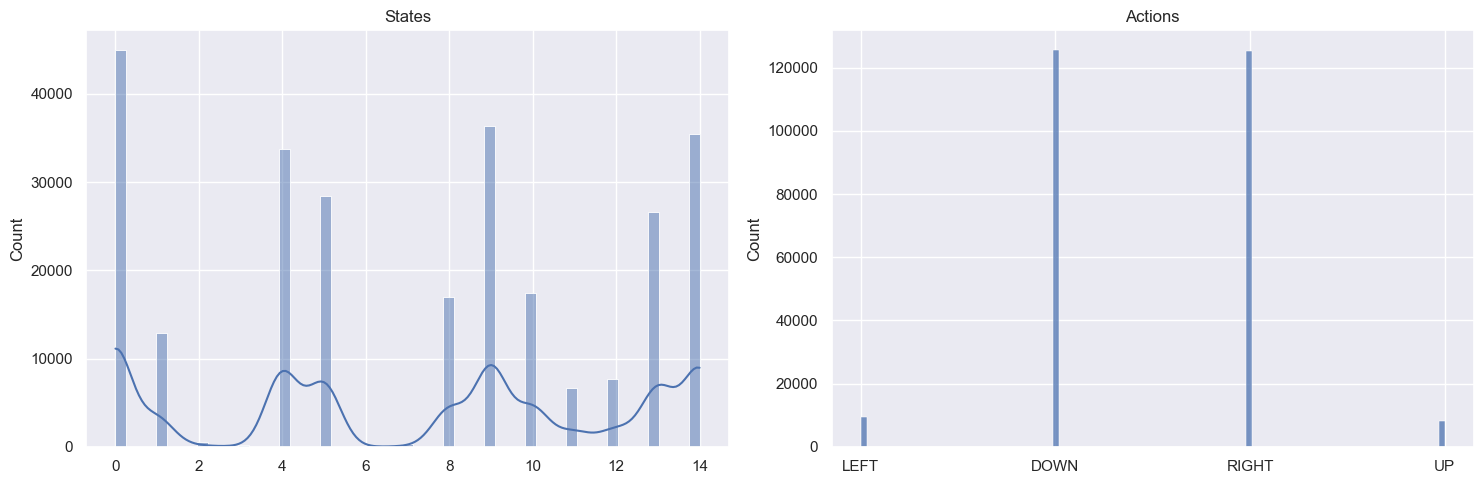

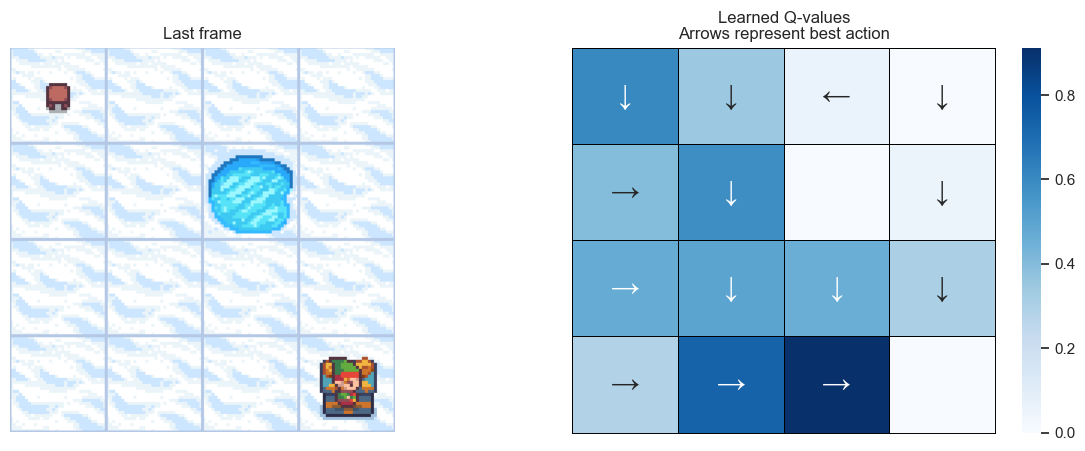

Map size: 7x7


Cumulative reward: 1761.0


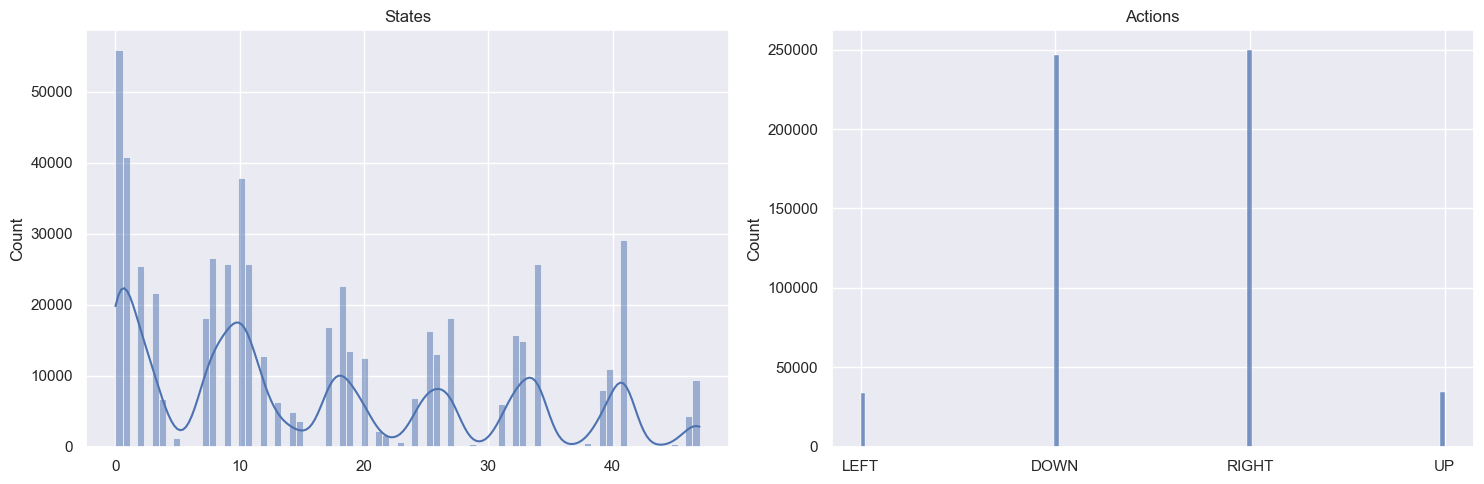

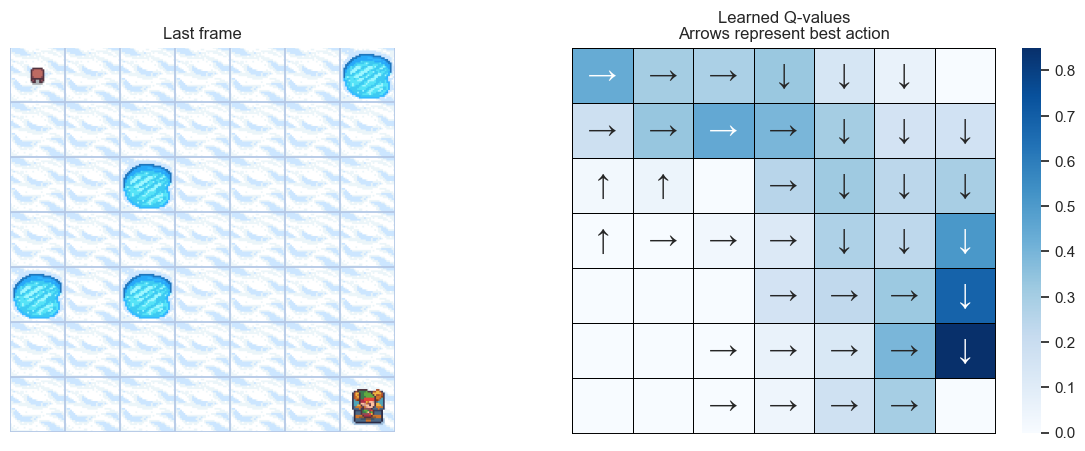

Map size: 9x9


Cumulative reward: 1063.0


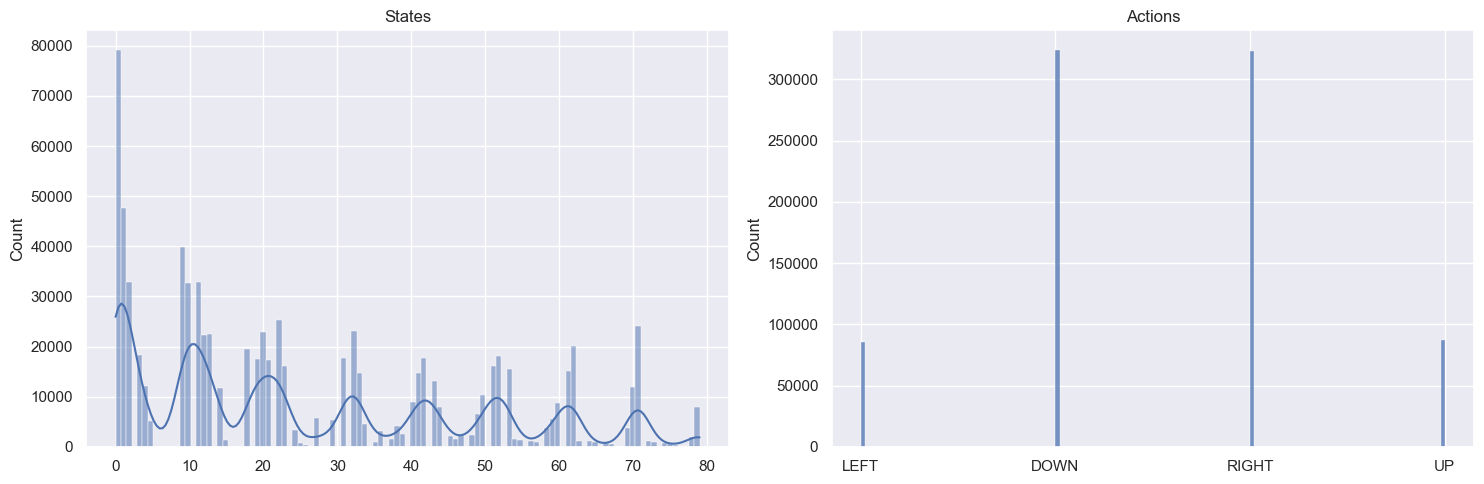

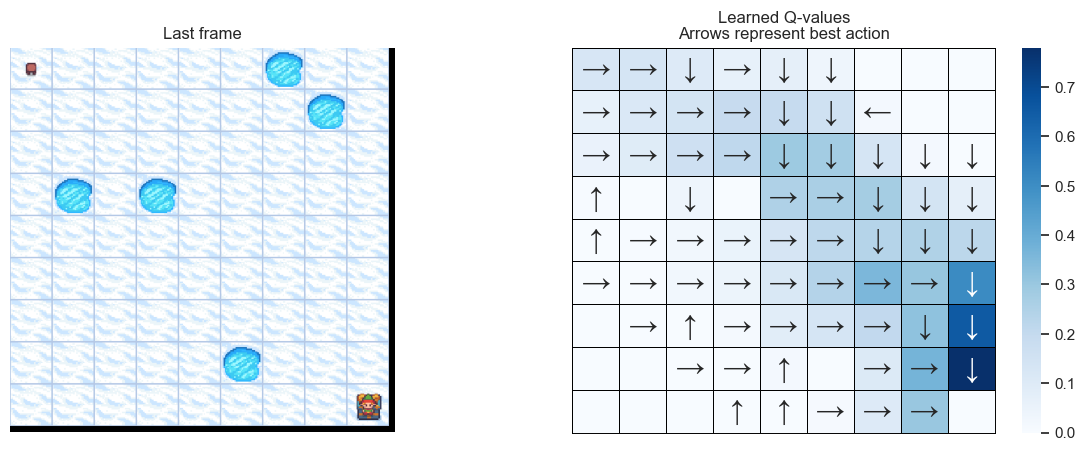

Map size: 11x11


Cumulative reward: 668.0


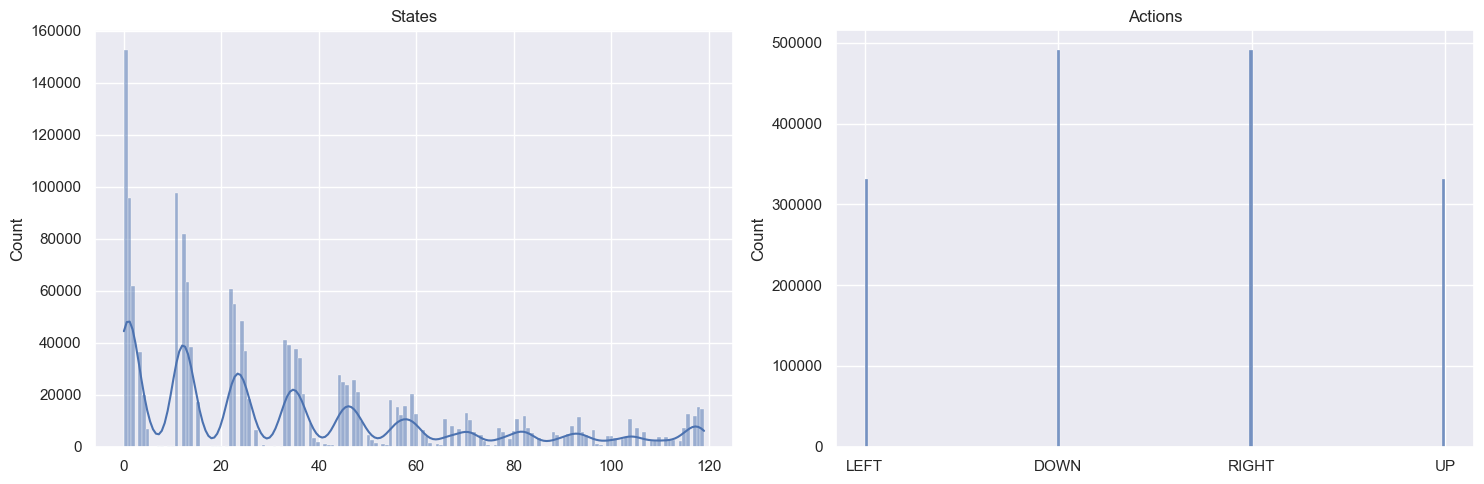

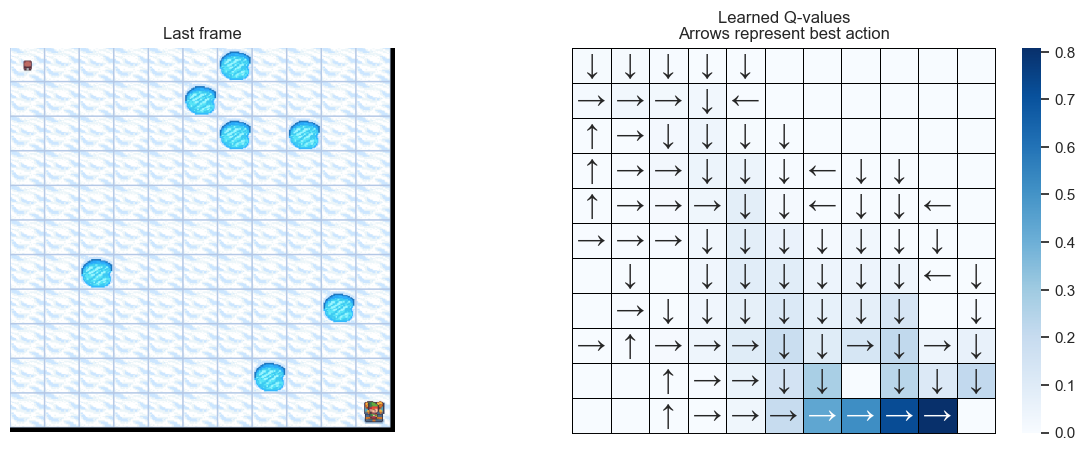


Running for learning rate=0.5
Map size: 4x4


Cumulative reward: 1979.0


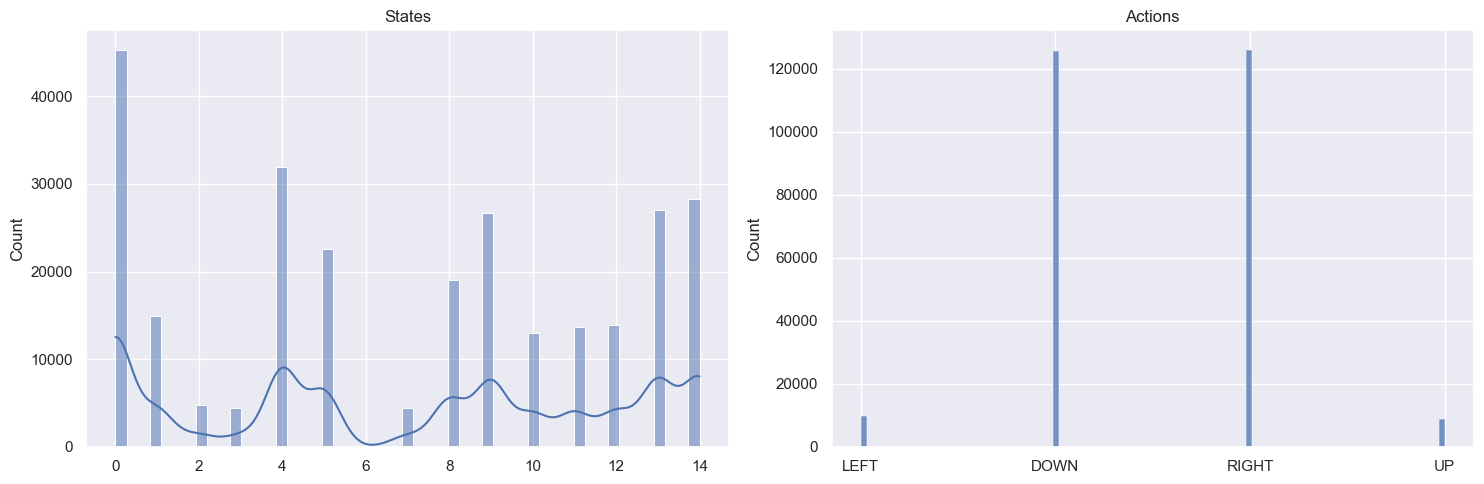

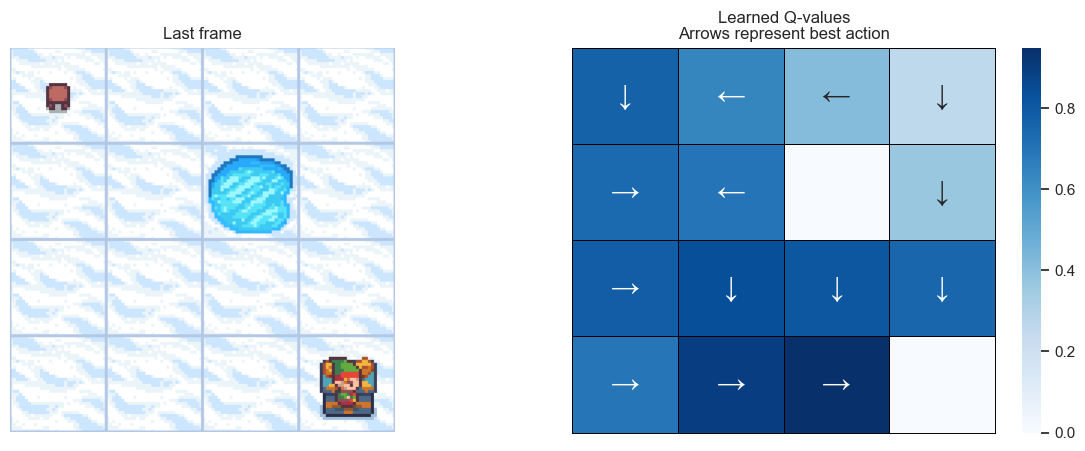

Map size: 7x7


Cumulative reward: 1827.0


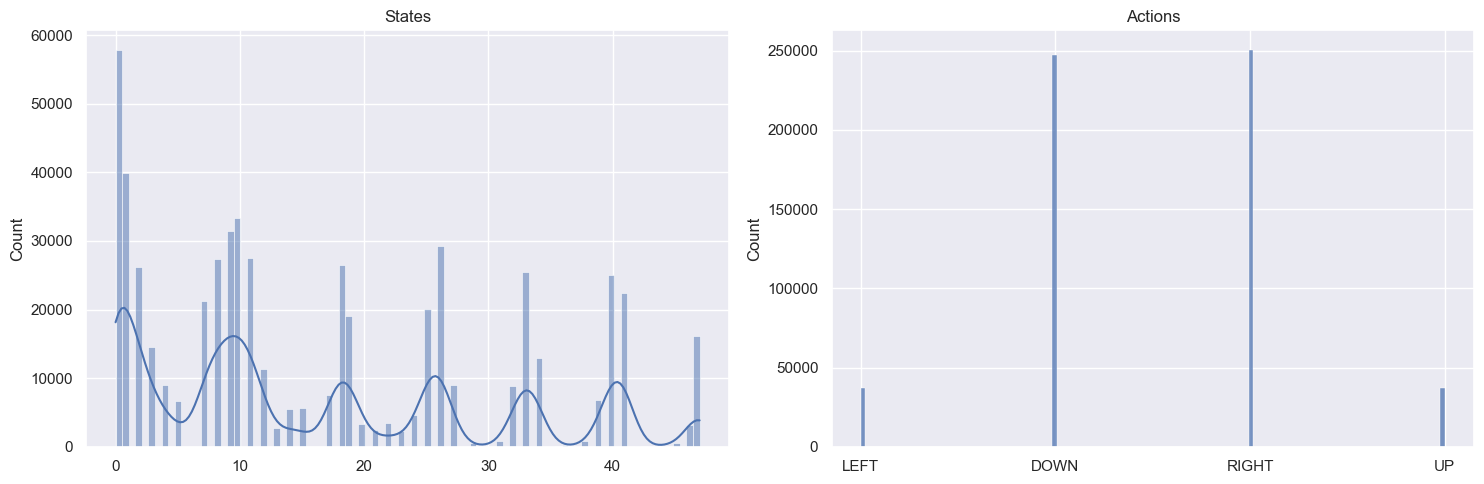

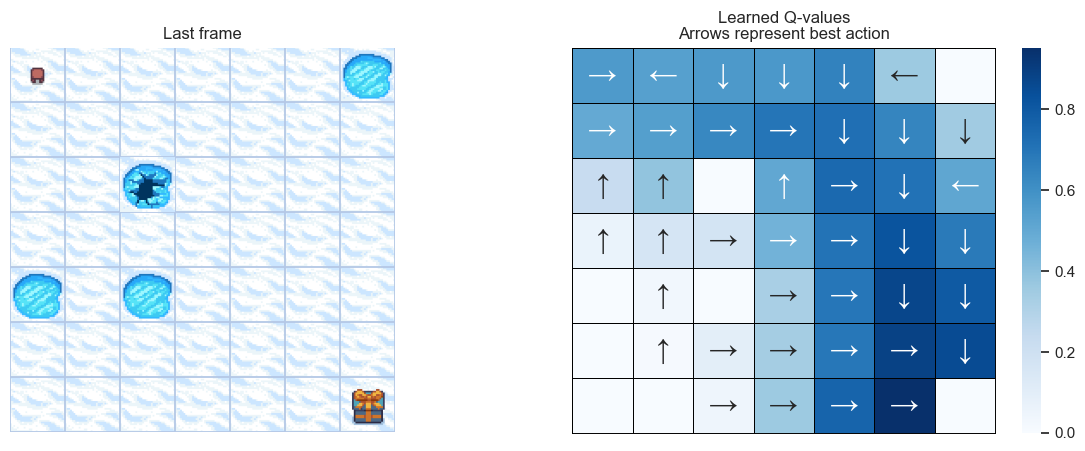

Map size: 9x9


Cumulative reward: 1541.0


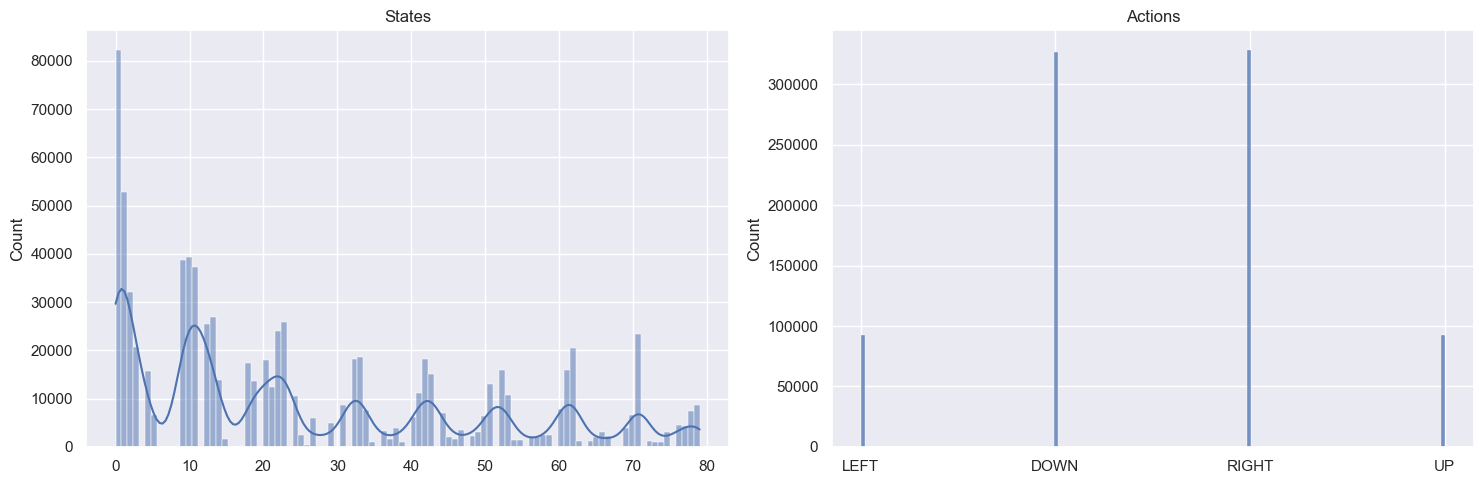

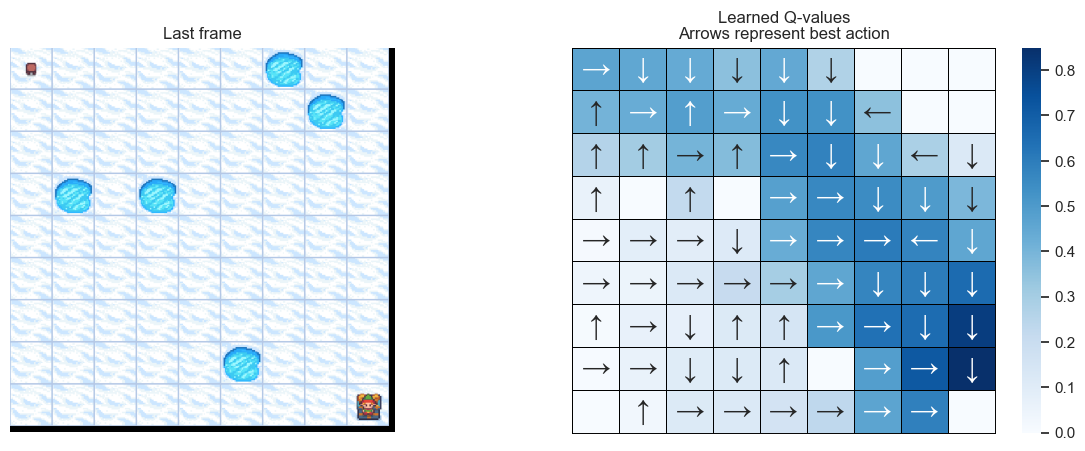

Map size: 11x11


Cumulative reward: 1103.0


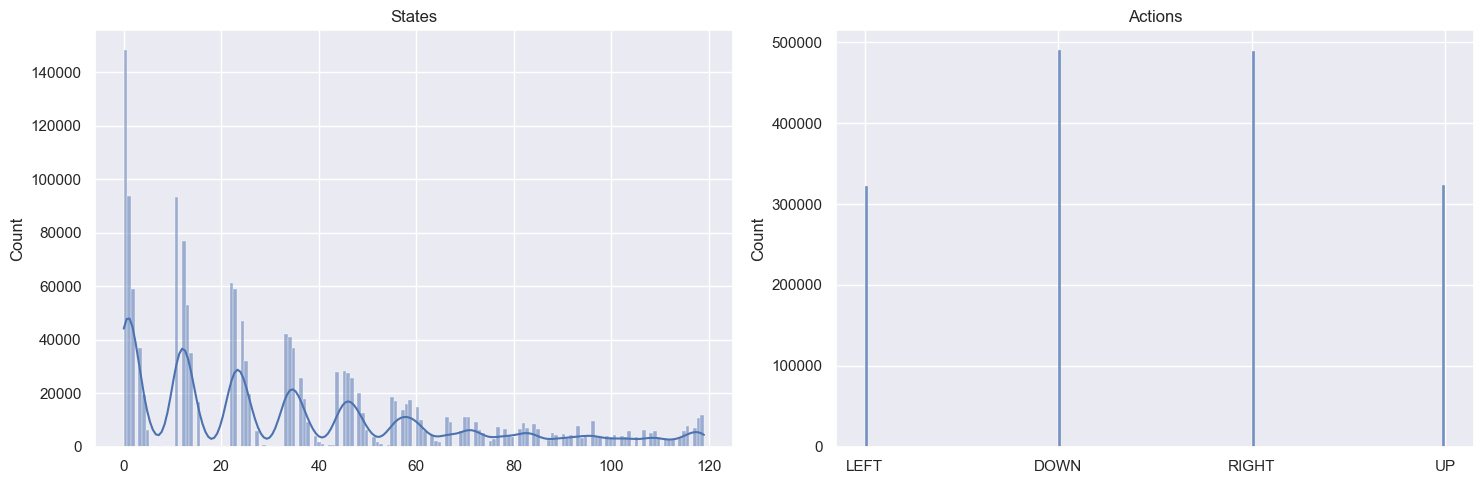

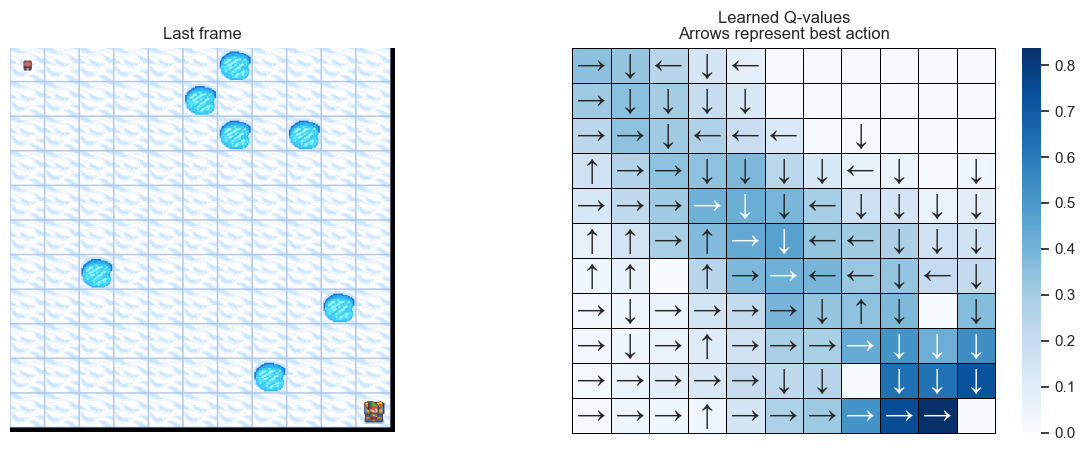


Running for learning rate=0.9
Map size: 4x4


Cumulative reward: 1986.0


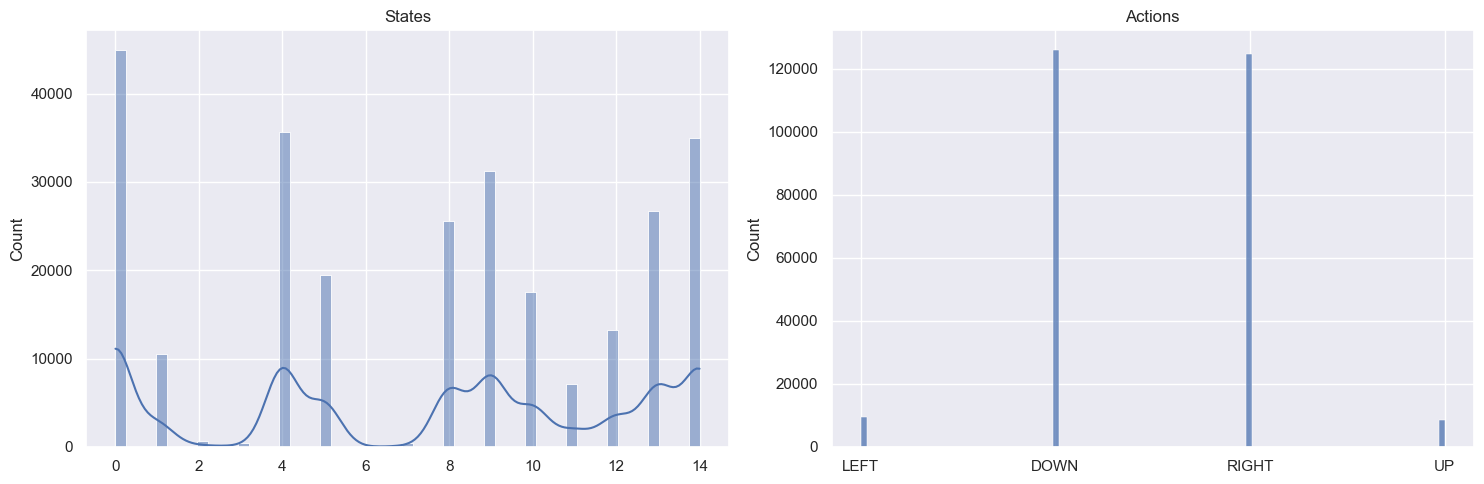

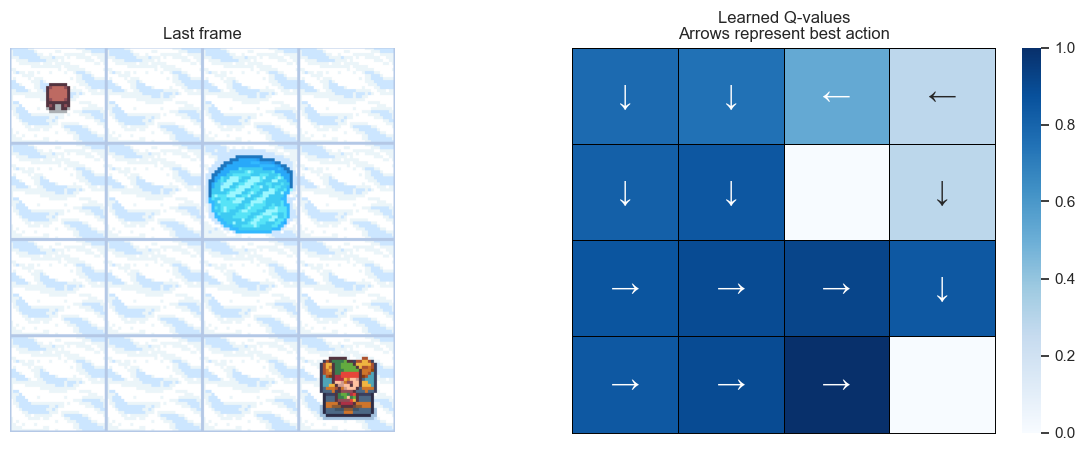

Map size: 7x7


Cumulative reward: 1824.0


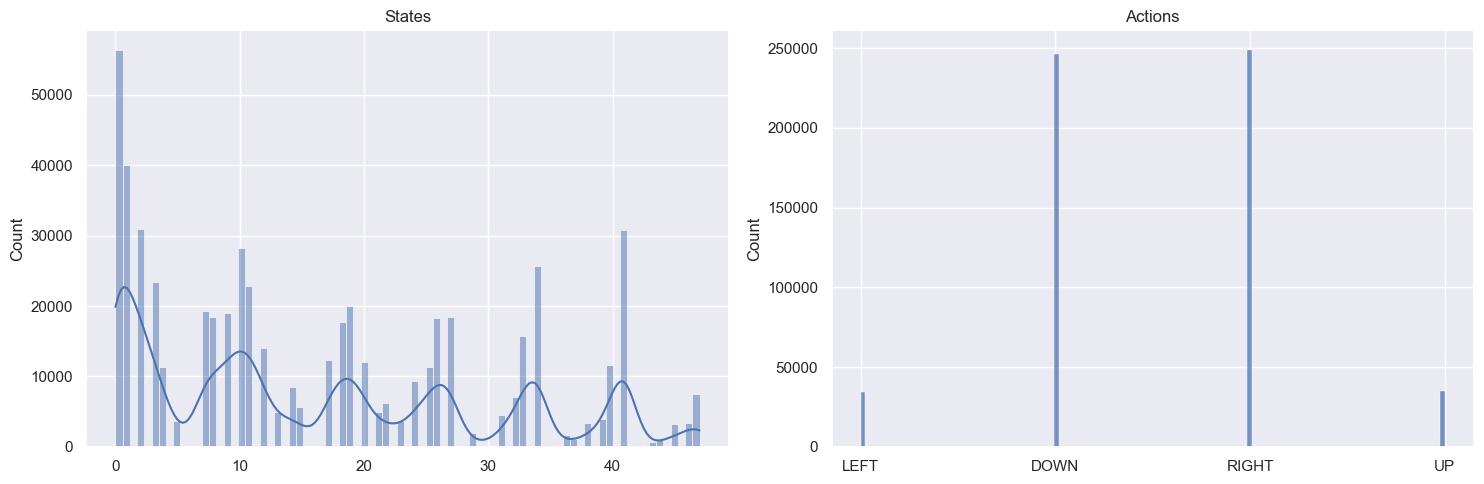

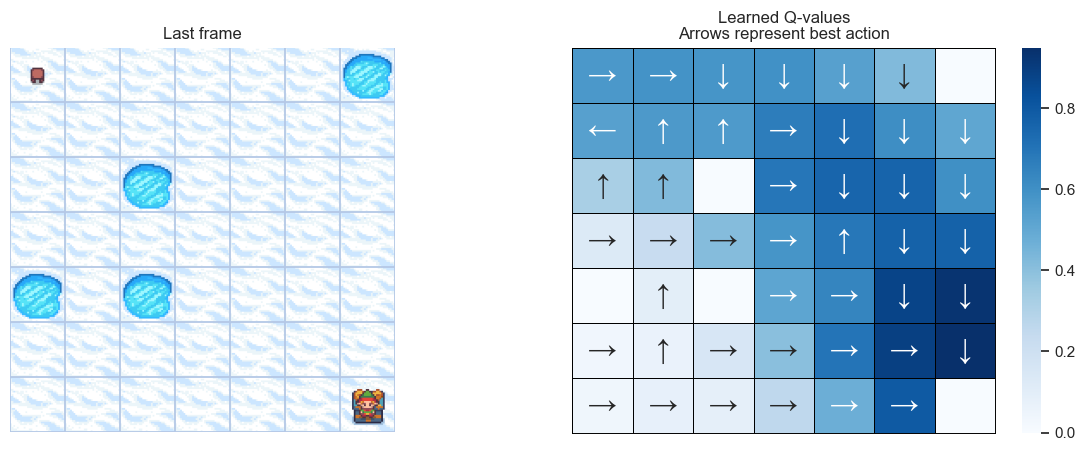

Map size: 9x9


Cumulative reward: 1239.0


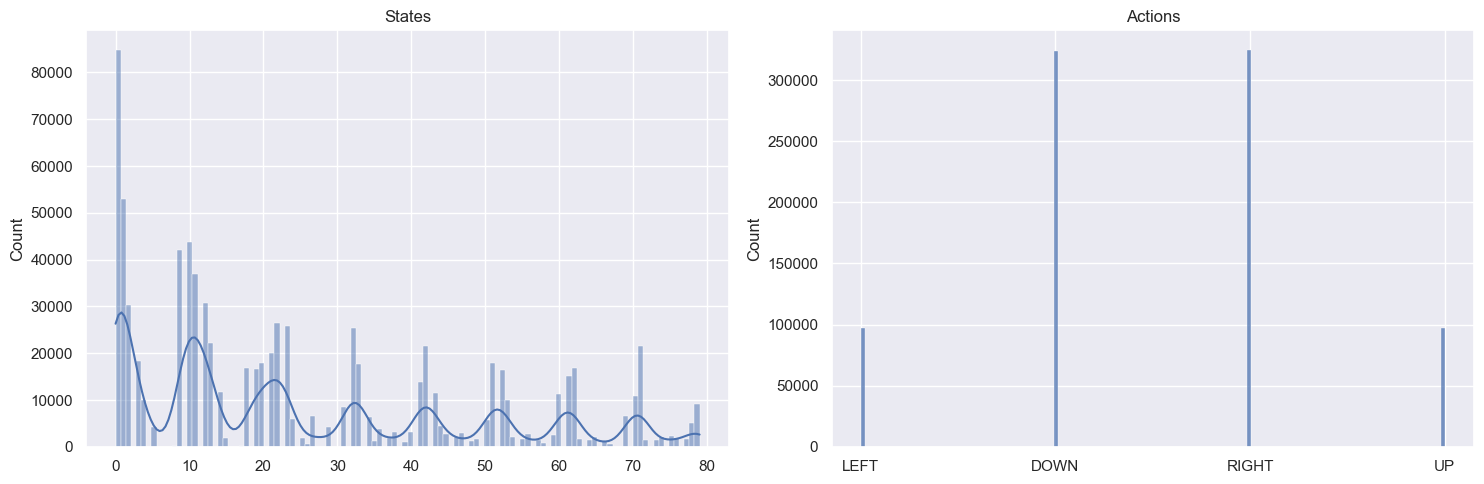

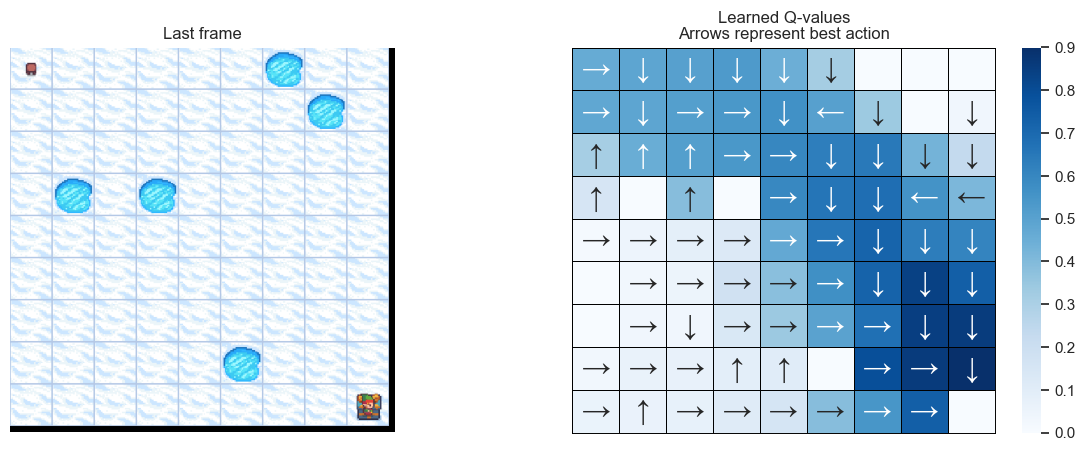

Map size: 11x11


Cumulative reward: 96.0


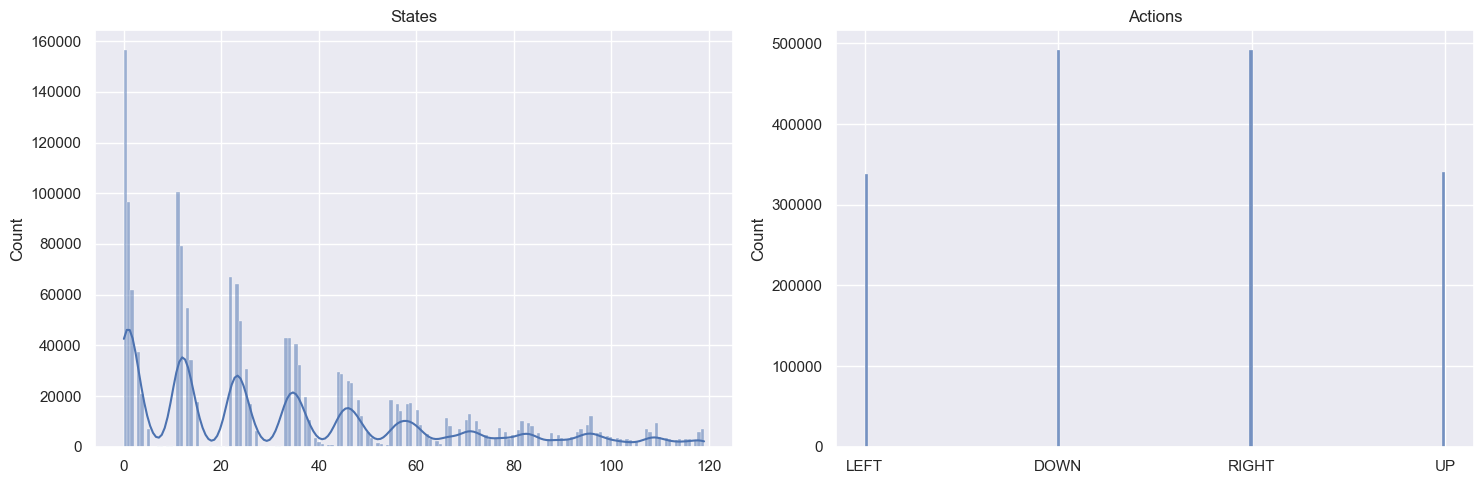

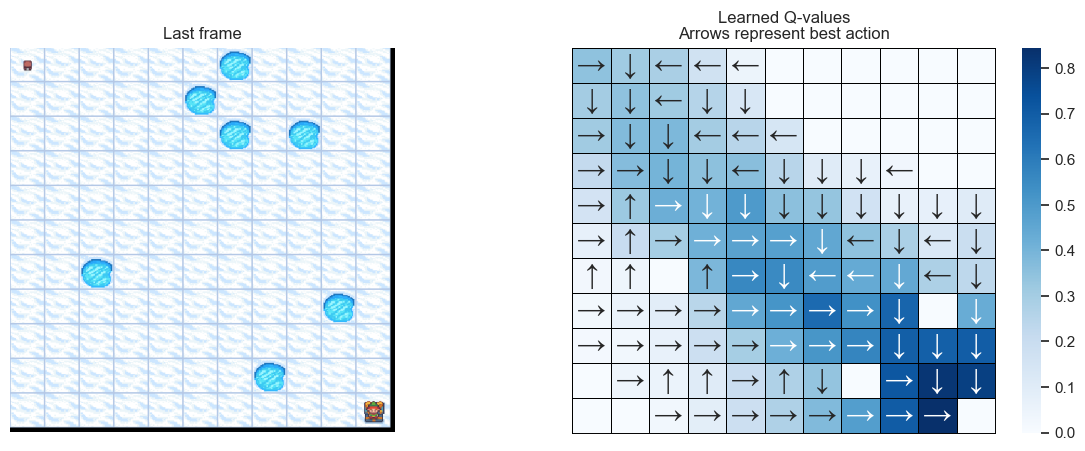

In [27]:
learning_rates = [0.01, 0.5, 0.9]
res_all = pd.DataFrame()
st_all = pd.DataFrame()
lr_results_summary = []

for lr in learning_rates:
    print(f"\nRunning for learning rate={lr}")

    updated_params = params._replace(
        learning_rate=lr,
        action_size=None,  
        state_size=None   
    )

    map_sizes = [4, 7, 9, 11]  
    for map_size in map_sizes:
        env = gym.make(
            "FrozenLake-v1",
            is_slippery=updated_params.is_slippery,
            render_mode="rgb_array",
            desc=generate_random_map(
                size=map_size, p=updated_params.proba_frozen, seed=updated_params.seed
            ),
        )

        updated_params = updated_params._replace(
            action_size=env.action_space.n,
            state_size=env.observation_space.n,
        )
        env.action_space.seed(updated_params.seed)

        learner = Qlearning(
            learning_rate=updated_params.learning_rate,
            gamma=updated_params.gamma,
            state_size=updated_params.state_size,
            action_size=updated_params.action_size,
        )
        explorer = EpsilonGreedy(epsilon=updated_params.epsilon)

        print(f"Map size: {map_size}x{map_size}")
        rewards, steps, episodes, qtables, all_states, all_actions = run_env(updated_params)

        res, st = postprocess(episodes, updated_params, rewards, steps, map_size)
        cumulative_reward = res["cum_rewards"].iloc[-1]
        print(f"Cumulative reward: {cumulative_reward}")
        lr_results_summary.append({
            "learning_rate": lr,
            "map_size": map_size,
            "cumulative_reward": cumulative_reward
        })

        res["learning_rate"] = lr
        res["map_size"] = map_size
        res_all = pd.concat([res_all, res])
        st_all = pd.concat([st_all, st])

        # Average the Q-table between runs 
        qtable = qtables.mean(axis=0)

        plot_states_actions_distribution(states=all_states, actions=all_actions, map_size=map_size)
        plot_q_values_map(qtable, env, map_size)

        env.close()

In [28]:
lr_summary_df = pd.DataFrame(lr_results_summary)
print(lr_summary_df)

    learning_rate  map_size  cumulative_reward
0            0.01         4             1904.0
1            0.01         7             1761.0
2            0.01         9             1063.0
3            0.01        11              668.0
4            0.50         4             1979.0
5            0.50         7             1827.0
6            0.50         9             1541.0
7            0.50        11             1103.0
8            0.90         4             1986.0
9            0.90         7             1824.0
10           0.90         9             1239.0
11           0.90        11               96.0


##### Observations: Relationship between learning rate and the cumulative reward
The learning rate vs. cumulative reward behavior is quite different. While the cumulative reward improves with increased learning rate from 0.01 to 0.50 for all map sizes, it degrades for a learning rate of 0.90, particularly for bigger maps (map size 11). This confirms that a moderate learning rate improves learning of the agent with a tradeoff of exploration vs. exploitation. A very high learning rate, however, results in cumulative reward deterioration, particularly for bigger maps. This indicates that a very high learning rate causes the agent to overshoot the optimal value, making it more prone to instability during learning.

##### Reasons:
The reason behind this observation lies in the trade-off between speed and accuracy in learning. Low learning rate (0.01) results in very slow updates, hence learning very slowly while missing rewards. Moderate learning rate (0.50) is a balanced trade-off, where learning is fast while the agent continues to adjust correctly to the environment. High learning rate (0.90) results in very large updates, making learning volatile, especially for more complex environments (larger maps), resulting in poor performance as the agent cannot fine-tune its strategy.

#### Question 2: Your next goal is to code a DDQN and solve the Lunar Lander V2 environment.

In [30]:
!pip install swig


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
!pip install "gymnasium[box2d]"


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import gymnasium as gym
import numpy as np
import torch
import matplotlib.pyplot as plt

from dqn import Agent 

In [38]:
env = gym.make("LunarLander-v3")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
seed = 0

In [39]:
agent = Agent(state_size, action_size, seed)

n_episodes = 2000
max_t = 1000
start = 1.0
end = 0.01
decay = 0.995

In [40]:
scores = []
eps = start
for i in range(1, n_episodes + 1):
    state, _ = env.reset()
    total_reward = 0
    for t in range(max_t):
        action = agent.act(state, eps)
        next_state, reward, done, truncated, _ = env.step(action)
        agent.step(state, action, reward, next_state, done or truncated)
        state = next_state
        total_reward += reward
        if done or truncated:
            break
    scores.append(total_reward)
    eps = max(end, decay * eps)

    if i % 100 == 0:
        average = np.mean(scores[-100:])
        print(f"Episode {i} Average Score: {average:.2f}")
        if average >= 200.0:
            print("Environment solved")
            break

Episode 100 Average Score: -171.38
Episode 200 Average Score: -88.89
Episode 300 Average Score: -63.05
Episode 400 Average Score: -2.45
Episode 500 Average Score: 94.40
Episode 600 Average Score: 189.31
Episode 700 Average Score: 187.32
Episode 800 Average Score: 227.91
Environment solved


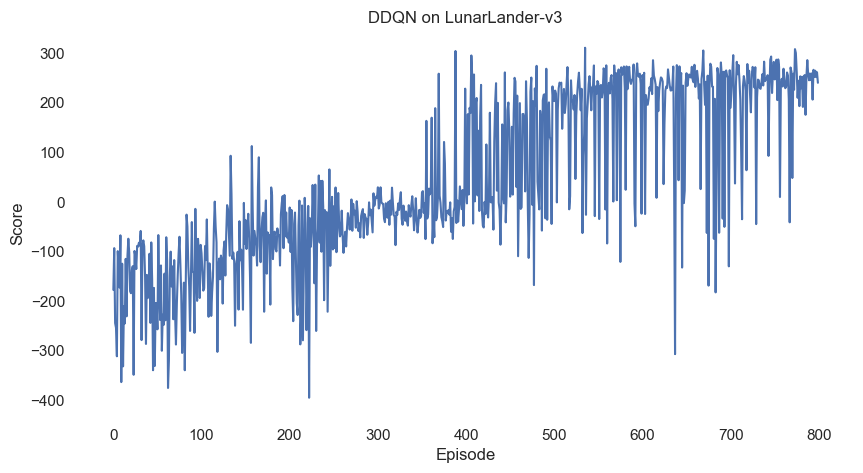

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("DDQN on LunarLander-v3")
plt.grid(False)
plt.gca().set_facecolor("white")
plt.show()